# Generalized Additive Model (GAM) with Local Polynomial Regression

### Import all the libraries

In [1]:
!pip install localreg
import pandas as pd

#
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#
import numpy as np
import matplotlib.pyplot as plt
from localreg import *
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Categorical, Real
import pstats
import cProfile
from scipy.stats import norm
from sklearn.inspection import permutation_importance

  Preparing metadata (setup.py) ... - done
  Created wheel for localreg: filename=localreg-0.5.0-py3-none-any.whl size=30916 sha256=fbffc33f1246e251fe8a8f9fb85a88c676304005ec3473292b59e1a4c3d32997
  Stored in directory: /root/.cache/pip/wheels/a0/71/4c/aa441c6905aeb082376f3ffe95b319c673a5caad19d483fe62
Successfully built localreg


### Define helper functions

In [2]:
def diagnostic_plots(fitted, y_val, y_pred, X_train, d, which_data_range):
    import scipy.stats as stats
    # Create a grid of subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    # Plot 1
    axes[0, 0].scatter(fitted['fitted'], fitted['residuals'], color='blue', s=5, alpha=0.5, label='Fitted vs. Residuals')
    axes[0, 0].set_xlabel('Fitted')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].grid(True)
    axes[0, 0].set_title('Fitted vs. Residuals')

    # Plot 2
    axes[0, 1].scatter(y_val, y_pred, color='blue', s=5, alpha=0.5)
    axes[0, 1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Diagonal line
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Predicted vs. Actual Plot')
    axes[0, 1].grid(True)

    # Plot 3
    axes[1, 0].hist(fitted['residuals'], bins=20, color='blue', edgecolor='black')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Histogram of Residuals')
    axes[1, 0].grid(True)

    # Plot 4
    stats.probplot(fitted['residuals'], dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')
    axes[1, 1].grid(True)

    # Plot 5
    X_train = np.array(X_train)
    axes[2, 0].scatter(X_train[:, d], fitted['residuals'], color='blue')
    axes[2, 0].set_xlabel(f'Predictor Variable {d}')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].set_title('Partial Residuals Plot')
    axes[2, 0].grid(True)
    
    # Plot 6
    axes[2, 1].plot(X_train[:, d][which_data_range] - np.mean(X_train[:,d]), color='red', label=f'X_train_{d} offset', alpha=0.5)
    axes[2, 1].plot(fitted['partials'][:, d][which_data_range], color='blue', label=f'Partial {d}', alpha=0.5)
    axes[2, 1].set_xlabel('Index')
    axes[2, 1].set_ylabel('Value')
    axes[2, 1].set_title('Partial Fits')
    axes[2, 1].legend()
    axes[2, 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()

# Function to fix the outliers by interpolation 
def fix_outliers(column):
    outliers = np.abs(column - np.mean(column)) > 2.5 * np.std(column)
    interpolated_values = interp1d(column.index[~outliers], column[~outliers], kind='linear')(column.index[outliers])
    column_fixed = column.copy()
    column_fixed[outliers] = interpolated_values
    return column_fixed

# Section I: Building up the functions

### localreg:
**Local polynomial regression is performed** using the function:
> localreg(x, y, x0=None, degree=2, kernel=rbf.epanechnikov, radius=1, frac=None)

We start by trying to understand how the `localreg`function behaves. To do so we pass it some synthetic data and we play around with the parameters to see how they affect the results.


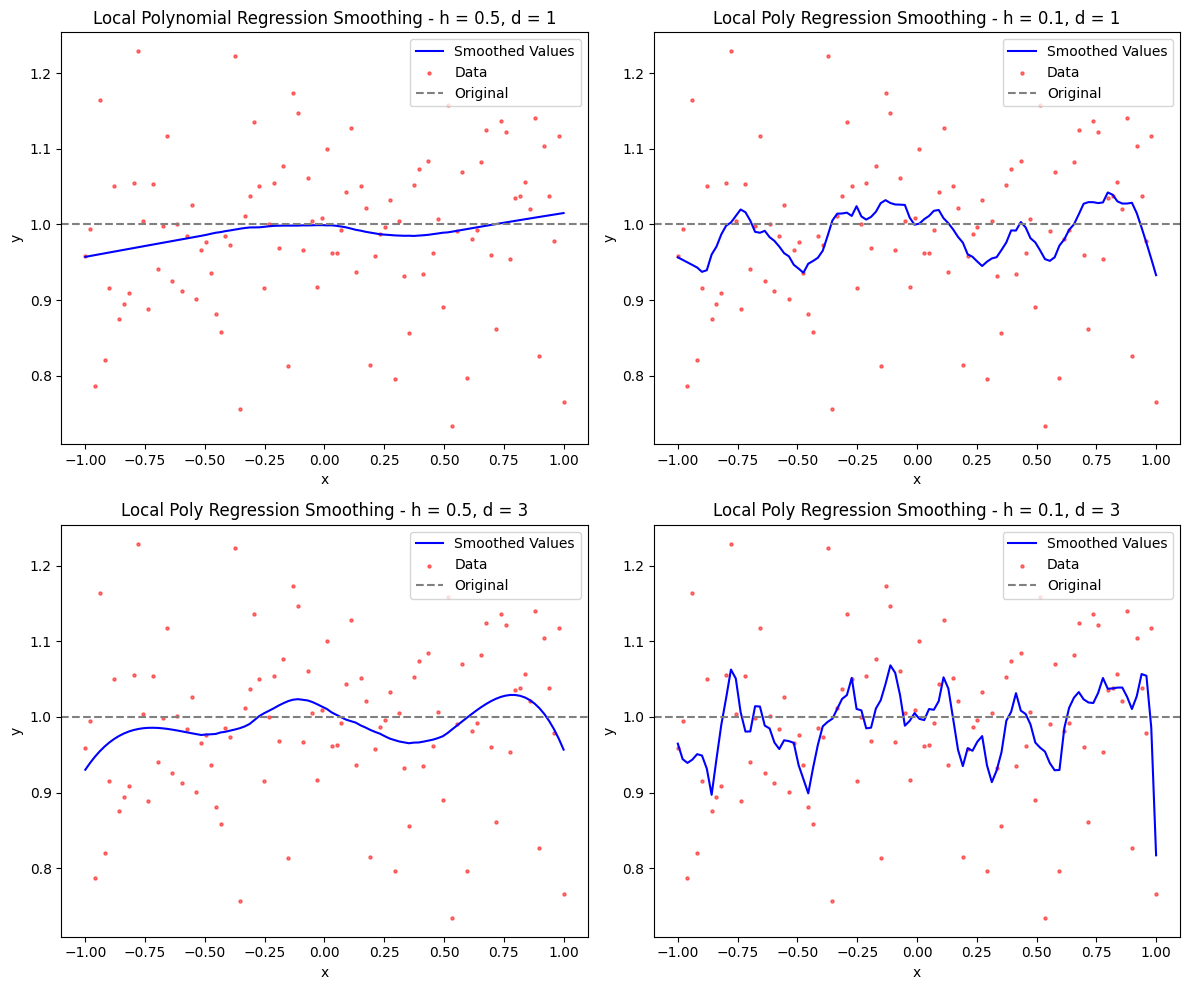

In [3]:
# Example usage of localreg smoothing
np.random.seed(2)

# Generate x values
x = np.linspace(-1, 1, num=100)

# Generate y values
y = np.random.normal(loc=1, scale=0.1, size=100)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First plot
smoothed_values = localreg(x, y, frac=0.5, degree=1)
axs[0, 0].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[0, 0].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Local Polynomial Regression Smoothing - h = 0.5, d = 1')
axs[0, 0].axhline(y=1, color='grey', linestyle='--', label='Original')
axs[0, 0].legend()

# Second plot
smoothed_values = localreg(x, y, degree=1, frac=0.1)
axs[0, 1].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[0, 1].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].set_title('Local Poly Regression Smoothing - h = 0.1, d = 1')
axs[0, 1].axhline(y=1, color='grey', linestyle='--', label='Original')
axs[0, 1].legend()

# Third plot
smoothed_values = localreg(x, y, degree=3, frac=0.5)
axs[1, 0].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[1, 0].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].set_title('Local Poly Regression Smoothing - h = 0.5, d = 3')
axs[1, 0].axhline(y=1, color='grey', linestyle='--', label='Original')
axs[1, 0].legend()

# Fourth plot
smoothed_values = localreg(x, y, degree=3, frac=0.1)
axs[1, 1].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[1, 1].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].set_title('Local Poly Regression Smoothing - h = 0.1, d = 3')
axs[1, 1].axhline(y=1, color='grey', linestyle='--', label='Original')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


When changing the degree of the polynomial (d) and the bandwidth (h), we affect the trade-off between bias and variance in our smoothing process. Higher degree polynomials and kernels with lower bandwith can capture more complex patterns in the data, but may also lead to overfitting the data. Moreover, we notice how higher degree polynomials exhibit big varaitions in the tails of the data, which is a common issue in polynomial regression.

### Centered Smoothing

Now we create a new function, `centered_smoothing`, to center the fit of the local polynomial regression around zero. We do this by subtracting the mean of the data from the smoothed values.

In [4]:
def centered_smoothing(x, y, degree=1, kernel=rbf.epanechnikov, bandwith=0.2):
    
    """"Smooths the values of y on x, 
    ensuring that the returned smooth values have a sample mean of 0.
    Parameters:
        x : The input values.
        y : The values to be smoothed.
    
    Returns: Smoothed values with a sample mean of 0.
    """
    # Perform Local smoothing
    smoothed_values = localreg(x, y, degree=degree, kernel=kernel, frac=bandwith)
    # Subtract mean
    smoothed_values -= np.mean(smoothed_values)
    return smoothed_values

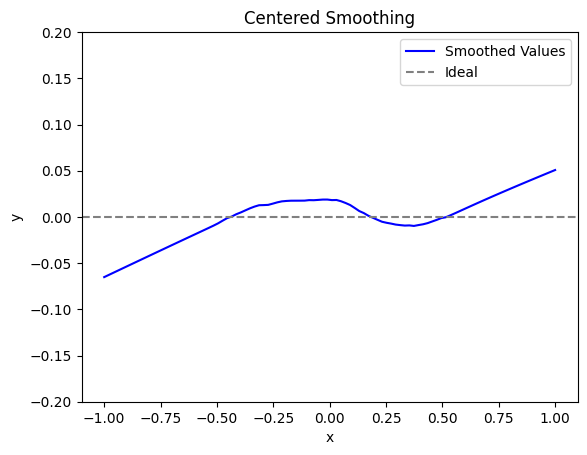

Mean: -3.552713678800501e-17


In [5]:
# Example usage of centered smoothing
np.random.seed(2)
# Generate x values
x = np.linspace(-1, 1, num=100)

# Generate y values
y = np.random.normal(loc=2, scale=0.2, size=100)

smoothed_values = centered_smoothing(x, y, bandwith=0.5)

# Plot the data
plt.plot(x, smoothed_values, label='Smoothed Values', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Centered Smoothing')
plt.axhline(y=0, color='grey', linestyle='--', label='Ideal')
plt.ylim(bottom=-0.2, top=0.2)
plt.legend()
plt.show()

print('Mean:', np.mean(smoothed_values))

Centered smoothing for a case where $E [Y |X = x] = 2$. The centered smoothing curve should be a flat line (shown in grey); here it varies between $-0.05$ and $0.05$, which is pretty good for only a hundred samples.
The average of the smoothed values, should ideally be zero, and is quite close to zero here.

We try one more example, to understand better the difference between the two functions.

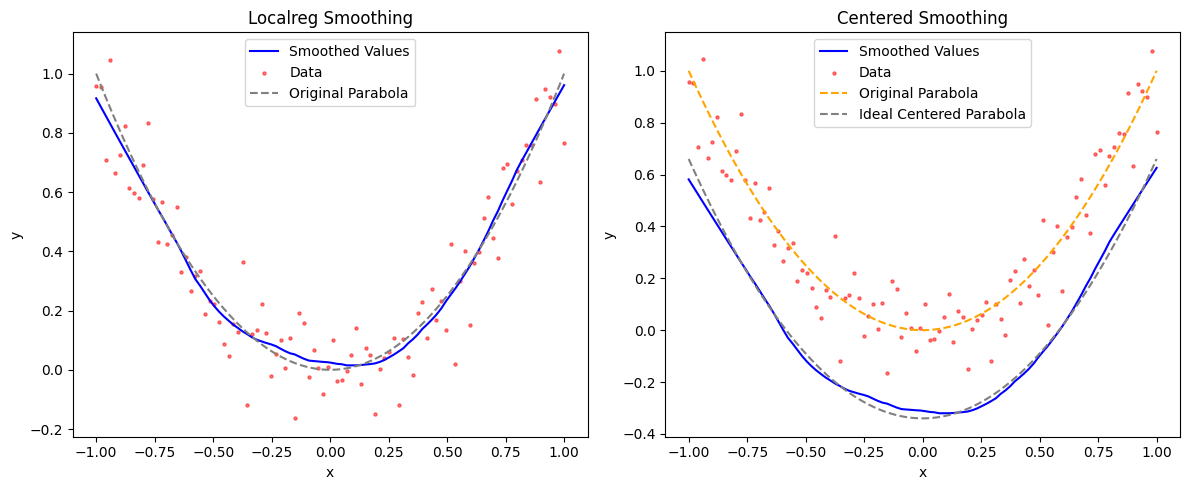

Mean localreg: 0.33538072956817144
Mean centered: 3.3306690738754695e-17


In [6]:
# Example 2
np.random.seed(2)

# Generate x values
x = np.linspace(-1, 1, num=100)

# Generate y values (parabola plus noise)
y = x**2 + np.random.normal(loc=0, scale=0.1, size=100)

# Calculate smoothed values for localreg
smoothed_values_localreg = localreg(x, y, degree=1, frac=0.2)

# Calculate smoothed values for centered smoothing
smoothed_values_centered = centered_smoothing(x, y)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for localreg smoothing
axs[0].plot(x, smoothed_values_localreg, label='Smoothed Values', color='blue')
axs[0].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[0].plot(x, x**2 , label='Original Parabola', color='grey', linestyle='--')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Localreg Smoothing')
axs[0].legend()

# Plot for centered smoothing
axs[1].plot(x, smoothed_values_centered, label='Smoothed Values', color='blue')
axs[1].scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
axs[1].plot(x, x**2 , label='Original Parabola', color='orange', linestyle='--')
axs[1].plot(x, x**2 - np.mean(x**2) , label='Ideal Centered Parabola', color='grey', linestyle='--')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Centered Smoothing')
axs[1].legend()

plt.tight_layout()
plt.show()

print('Mean localreg:', np.mean(smoothed_values_localreg))
print('Mean centered:', np.mean(smoothed_values_centered))

Again we see that, as we would like, the centered smoothing curve is centered around zero and that the centereed smoothing curve is shifted with respect to the data points, by a value that is exactly the mean of the local polynomial smoothed curve, thus everything seems to be correct.

Let's try with one more shape.

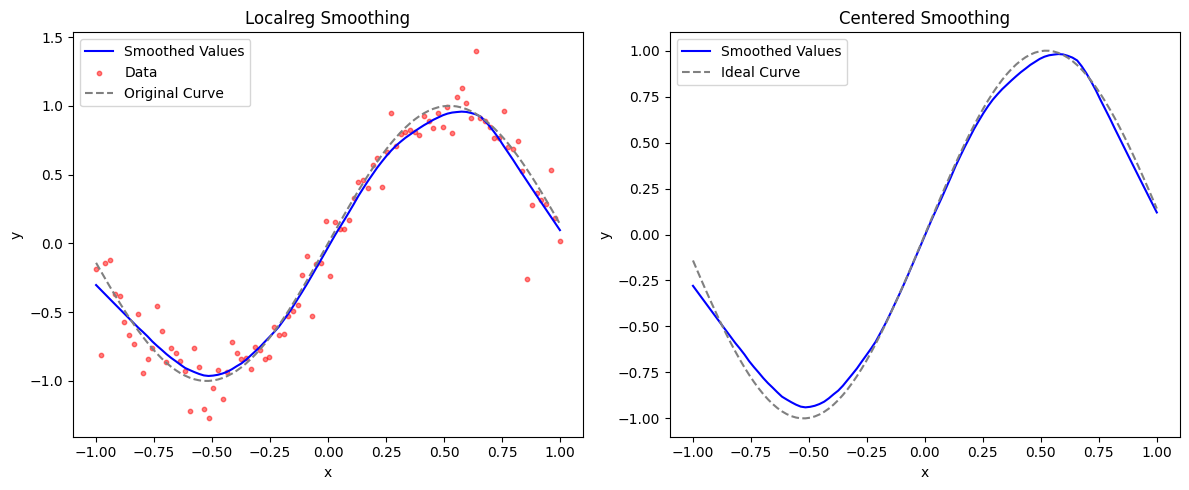

In [7]:
# Generate x values
np.random.seed(2)
x = np.linspace(-1, 1, num=100)

# Generate y values
y = np.sin(3 * x) + 0.1 * np.random.standard_t(df=3, size=100)  # Changed tanh to sin

# Calculate smoothed values using localreg
smoothed_values = localreg(x, y, degree=1, frac=0.2)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for localreg smoothing
axs[0].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[0].scatter(x, y, label='Data', color='red', s=10, alpha=0.5)
axs[0].plot(x, np.sin(3 * x), label='Original Curve', color='grey', linestyle='--')  # Changed tanh to sin
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Localreg Smoothing')
axs[0].legend()

# Plot for centered smoothing
smoothed_values = centered_smoothing(x, y)
axs[1].plot(x, smoothed_values, label='Smoothed Values', color='blue')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Centered Smoothing')
axs[1].plot(x, np.sin(3 * x), label='Ideal Curve', color='grey', linestyle='--')  # Changed tanh to sin
axs[1].legend()

plt.tight_layout()
plt.show()

Again we are happy with our results, as the centered smoothing curve is centered around zero, and this time it is not shifted because the function is odd and oscillates round zero.

### Backfit

Now, we create a `backfit` function which plays a key role in the backfitting algorithm for fitting additive models. It is a single iteration of the more general backfitting method. The backfit function updates the partials by smoothing the residuals with respect to each feature in $X$.

The function takes five parameters: `x` (the features or covariates), `residuals` (the residuals, representing the differences between the observed values and the fitted values obtained so far), `m` (the partials, representing the current fitted values for each feature), `kernel` (the kernel function used for smoothing, with the default being rbf.epanechnikov), `bandwidth` (the bandwidth parameter for smoothing, with the default being 0.2), and `degree` (the degree of the polynomial for smoothing, with the default being 1).

Here's a breakdown of how the function works:

- It first creates a copy of the residuals array to avoid modifying the original data.
- It initializes the array $g$ with the current partials array $m$.
- It loops over each feature of $X$ and within each iteration:
    - it computes the partial residuals by adding the corresponding column of $m$ to the current residuals.
    - It performs centered smoothing on  the partial residuals with respect to $X_j$ using the `centered_smoothing` function with the specified kernel, bandwidth, and degree, and updates the corresponding column of $g$ with the smoothed values.
    - It updates the residuals by subtracting the smoothed values from the corresponding column of $m$ and adding them back to the residuals.
- Finally, it returns the updated partials array $g$.

In [8]:
def backfit(x, residuals, m, kernel=rbf.epanechnikov, bandwith=0.2, degree=1):
    """
    This function, backfit, is used within the backfitting algorithm for additive models.
    
    Parameters:
        x : numpy array
            The features or covariates.
        residuals : numpy array
            The residuals.
        m : numpy array
            The partials.
        kernel : function, optional
            The kernel function used for smoothing. Default is rbf.epanechnikov.
        bandwidth : float, optional
            The bandwidth parameter for smoothing. Default is 0.2.
        degree : int, optional
            The degree of the polynomial for smoothing. Default is 1.
    
    Returns:
        g : numpy array
            The updated partials array.
    """
    residuals_copy = residuals.copy()
    # Check inputs
    if x.shape[0] != residuals.shape[0] or x.shape[0] != m.shape[0]:
        raise ValueError("x, residuals, and m must have the same number of rows")
    if len(x.shape) == 1:
        p = 1
    else:
        p = x.shape[1]
    # Initialize g with m
    g = m.copy()
    # Loop over each dimension
    for j in range(p):
        # Compute partial residuals
        partial_residuals = residuals_copy + m[:, j]
        # Extract column j of x
        x_j = x[:, j].reshape(-1,) if p > 1 else x.reshape(-1, )
        # Perform centered smoothing
        g[:, j] = centered_smoothing(x_j, partial_residuals, degree=degree, kernel=kernel, bandwith=bandwith)
        # Update residuals
        residuals_copy += (m[:, j] - g[:,j])
    return g

### Backfitting algorithm

Next, we creat the function `backfit_additive_model`, which implements the backfitting algorithm for fitting additive models leveraging the `backfit` and `centered_smoothing` functions previoulsy defined.

It takes seven parameters: `X` (the features), `y` (the target variable), `max_iter` (the maximum number of iterations for backfitting), `tol` (the tolerance level for convergence), `kernel` (the kernel function used for smoothing), `bandwidth` (the bandwidth parameter for smoothing), and `degree` (the degree of the polynomial for smoothing).

Here's a breakdown of how the function works:

- It initializes the intercept $\alpha$ as the mean of the target variable $y$ and initializes the residuals as the differences between $y$ and $\alpha$.
- It initializes the partials $m$ as a matrix of zeros.
- It calculates the initial residual sum of squares ($rss_0$) based on the initial residuals.
- It iterates the backfitting process until convergence or until the maximum number of iterations is reached.
- Within each iteration:
    - It performs backfitting using the backfit function to update the partials $m$.
    - It computes the change in the fitted values by updating the residuals based on the difference between the previous and current partials.
    - It checks for convergence by comparing the change in residual sum of squares ($rss$) with the tolerance level.
    - If convergence is achieved, i.e. if $abs(rss - rss_0) < tol \cdot rss$, it breaks out of the loop; otherwise, it updates $rss_0$ and continues the iterations.
- It computes the fitted values by adding the intercept $\alpha$ to the sum of the partials $m$.
- Finally, it returns a dictionary containing the fit results, including fitted values, residuals, means, partials, and convergence information.

In [9]:
def backfit_additive_model(X, y, max_iter=100, tol=1e-6, kernel=rbf.epanechnikov, bandwith=0.2, degree=1):
    """
    This function implements the backfitting algorithm for fitting additive models.

    Parameters:
        X : numpy array
            The features or covariates.
        y : numpy array
            The target variable.
        max_iter : int, optional
            The maximum number of iterations for backfitting. Default is 100.
        tol : float, optional
            The tolerance level for convergence. Default is 1e-6.
        kernel : function, optional
            The kernel function used for smoothing. Default is rbf.epanechnikov.
        bandwidth : float, optional
            The bandwidth parameter for smoothing. Default is 0.2.
        degree : int, optional
            The degree of the polynomial for smoothing. Default is 1.

    Returns:
        fit : dict
            A dictionary containing the fit results including fitted values, residuals, means, partials, and convergence information.
    """
    # Check inputs
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of rows")
    n, d = X.shape
    
    # Initialize alpha, residuals and partials
    alpha = np.mean(y)
    residuals = y - alpha # Initialize residuals
    m = np.zeros((n, d)) # Initialize partials to 0
    
    rss0 = np.sum(residuals**2)
    
    # Perform backfitting until convergence
    iteration = 0
    while iteration < max_iter:
        # Perform backfitting
        g = backfit(X, residuals, m, kernel=kernel, bandwith=bandwith, degree=degree)
        
        # Update residuals
        residuals += (np.sum(m, axis=1) - np.sum(g, axis=1))
        # Compute RSS
        rss = np.sum(residuals**2)
        
        # Check for convergence
        if np.abs(rss - rss0) < (tol*rss):
            break
        else:
            rss0 = rss
            
        # Update m
        m = g.copy()
        # Increment iteration
        iteration += 1
    
    # Compute fitted values
    fitted = alpha + np.sum(m, axis=1)
    
    # Return the fit results
    fit = {
        'fitted': fitted,
        'residuals': residuals,
        'mean': alpha,
        'partials': m,
        'rss0': rss0,
        'rss':rss,
        'x': X,
        'converged': iteration < max_iter,
        'iterations': iteration,
        'tol': tol
    }
    return fit

#### Example - 1d case

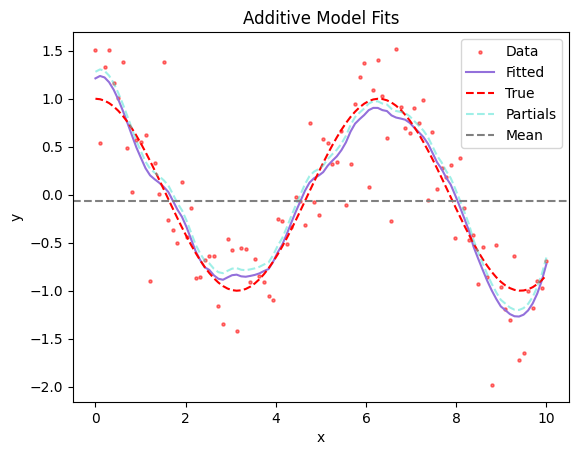

Converged: True
Iterations: 1
RSS: 15.026289488436248
RSS0: 15.026289488437186


In [10]:
# Example usage of the backfit_additive_model function
# Generate synthetic data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.cos(x) + 0.3 * np.random.standard_t(df=3, size=100)

# Apply additive modeling
fit = backfit_additive_model(x,y, bandwith=0.2, degree=3)

# Print the result
plt.scatter(x, y, label='Data', color='red', s=5, alpha=0.5)
plt.plot(fit['x'], fit['fitted'], label='Fitted', color='mediumpurple')
plt.plot(x, np.cos(x), label='True', color='red', linestyle='--')
plt.plot(fit['x'], fit['partials'], label='Partials', color='turquoise', linestyle='--', alpha=0.5)
plt.axhline(y=fit['mean'], color='grey', linestyle='--', label='Mean')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Additive Model Fits')
plt.legend()
plt.show()

print('Converged:', fit['converged'])
print('Iterations:', fit['iterations'])
print('RSS:', fit['rss'])
print('RSS0:', fit['rss0'])

The algortihm converged in just one iteration and, from the plot, we notice it was able to capture the underlying pattern in the data quite well.

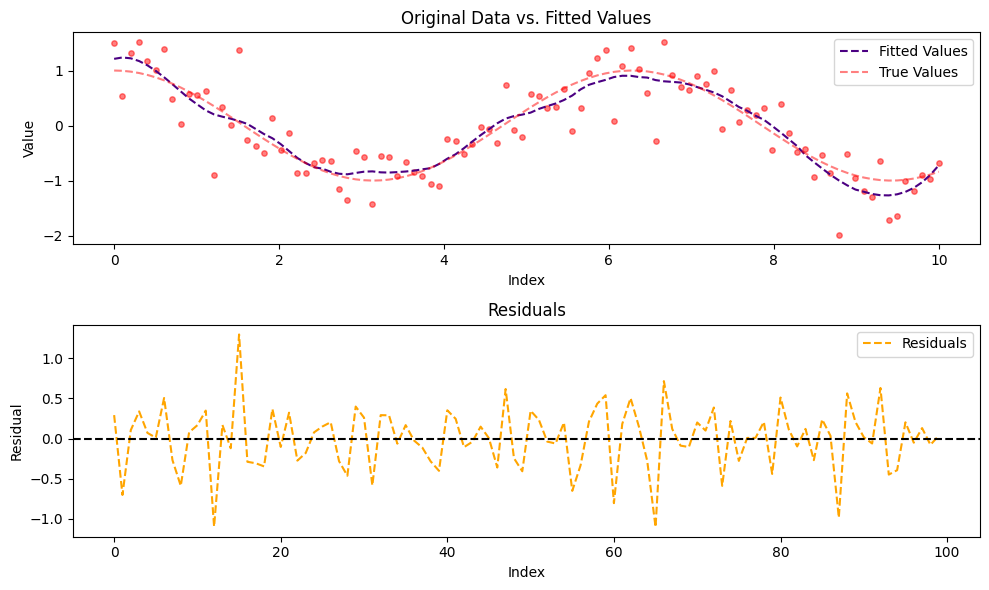

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(x, y, color = "red", s=15, alpha=0.5)
plt.plot(x, fit['fitted'], label='Fitted Values', linestyle='--', color='indigo')
plt.plot(x, np.cos(x), label='True Values', linestyle='--', color='red', alpha=0.5)
plt.title('Original Data vs. Fitted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fit['residuals'], label='Residuals', color='orange', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()

We notice that the residuals are centered around zero, which is a good sign of a well-fitted model and the spikes in residuals correspond to the points where the model deviates from the data points.

#### Example - 3d case

Let's now test our algorithm with more complex data.

In [12]:
# Generate synthetic data
np.random.seed(1)
x = np.column_stack((np.random.uniform(-2, 2, 100), np.random.randn(100), np.random.exponential(scale=2, size=100)))
y = np.sin(x[:, 0]) + x[:, 1]**2 + x[:, 2]  + 0.3*np.random.standard_t(df=3, size=100)

# Apply additive modeling
fit = backfit_additive_model(x, y, bandwith=0.2, tol=1e-5, degree=1)

# Print the result
print("tol:", fit['tol'])
print("iterations:", fit['iterations'])
print("RSS:", fit['rss'])
print("RSS0:", fit['rss0'])

tol: 1e-05
iterations: 9
RSS: 15.143417401465442
RSS0: 15.143308589599773


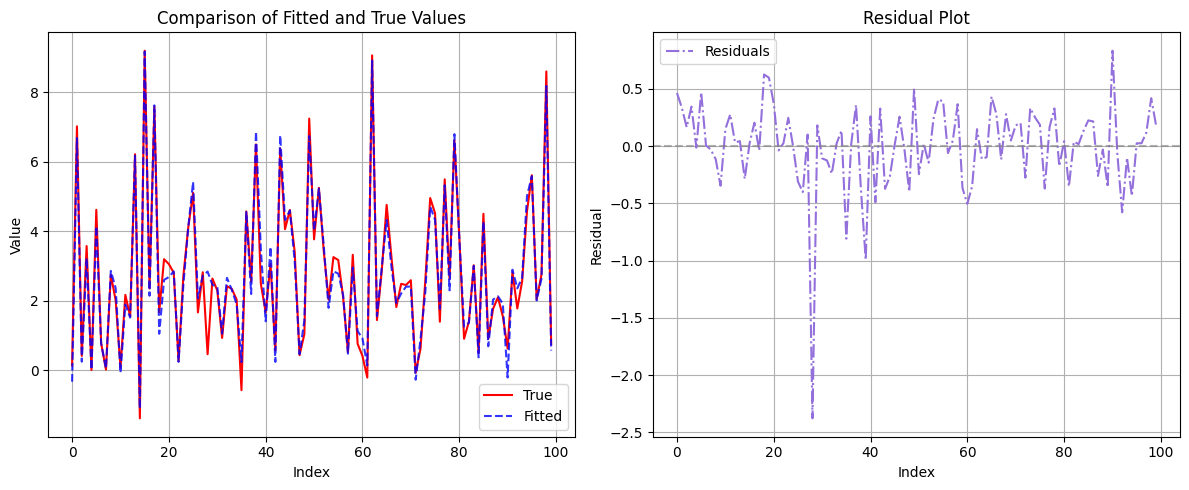

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot of fitted and true values
axs[0].plot(y, label='True', color='red')
axs[0].plot(fit['fitted'], label='Fitted', color='blue', alpha=0.8, linestyle='--')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Comparison of Fitted and True Values')
axs[0].legend()
axs[0].grid(True)

# Plot of residuals
axs[1].plot(fit['residuals'], label='Residuals', color='mediumpurple', linestyle='-.')
axs[1].axhline(y=0, color='grey', linestyle='--', alpha=0.6)  # Adding horizontal line at y=0
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residual Plot')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Even with this more complex data, the algorithm seems to be working well, as the residuals are centered around zero and the fitted values capture the underlying pattern in the data.

Now we try to run a single further iteration of backfitting leveraging the backfit function.

In [14]:
g = backfit(x, fit['residuals'], fit['partials'])
# Calculate the summary statistics of the differences
diff_summary = {
    f'Dimension {i+1}': {
        'Mean difference': np.mean(g[:, i] - fit['partials'][:, i]),
        'Standard deviation of difference': np.std(g[:, i] - fit['partials'][:, i]),
        'Maximum difference': np.max(np.abs(g[:, i] - fit['partials'][:, i])),
        'Minimum difference': np.min(np.abs(g[:, i] - fit['partials'][:, i]))
    }
    for i in range(fit['partials'].shape[1])
}

# Print the summary statistics
for dimension, stats in diff_summary.items():
    print(f"{dimension}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name}: {stat_value}")

Dimension 1:
  Mean difference: 3.2474023470285827e-17
  Standard deviation of difference: 2.153331289500739e-05
  Maximum difference: 4.993761245331019e-05
  Minimum difference: 2.9765956044425224e-07
Dimension 2:
  Mean difference: 1.1102230246251566e-17
  Standard deviation of difference: 1.3087064946599131e-05
  Maximum difference: 2.792475113666537e-05
  Minimum difference: 1.3227500017531924e-07
Dimension 3:
  Mean difference: -4.718447854656916e-18
  Standard deviation of difference: 1.3425471329379703e-05
  Maximum difference: 4.907924493480209e-05
  Minimum difference: 6.035811157545368e-07


Indeed, we see that the difference betweeen the average difference between the partials before and after the additional iteration is very small, close to zero, indicating our model is well-fitted.

It is now time to look at the partials to see if the model was able to reconstruct for each feature the underlying pattern in the data.

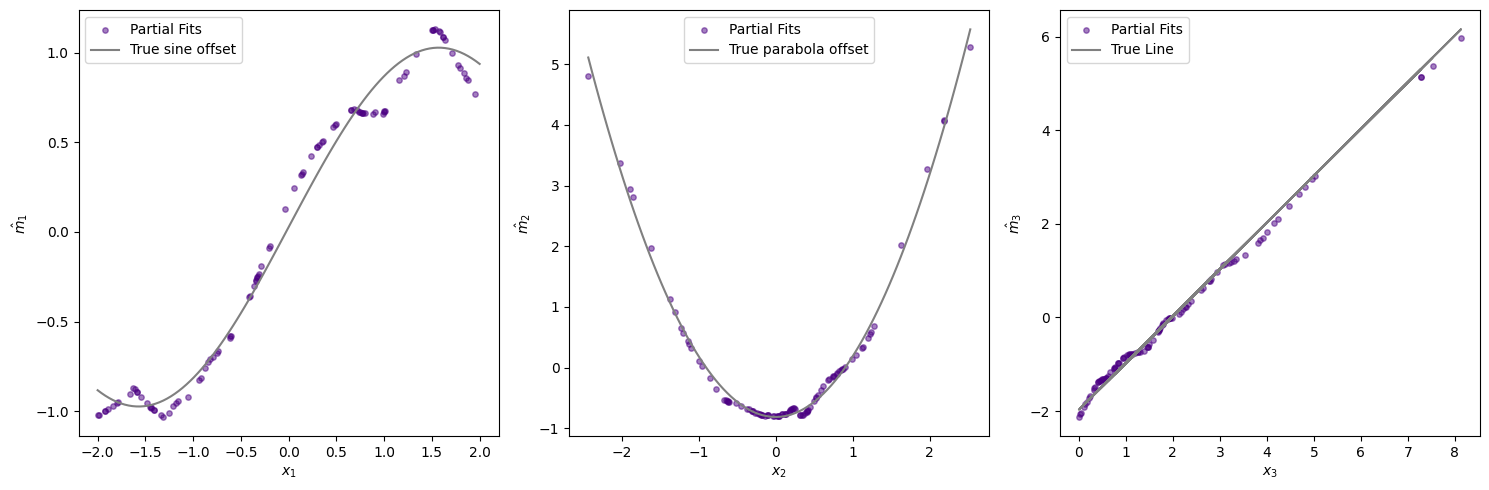

Mean m1:  -2.220446049250313e-18
Mean m2:  6.661338147750939e-18
Mean m3:  -2.2204460492503132e-17


In [15]:
plt.figure(figsize=(15, 5))

# Plot 1
plt.subplot(1, 3, 1)
plt.scatter(x[:, 0], fit['partials'][:, 0], label='Partial Fits', color='indigo', s=15, alpha=0.5)
sin_offset = np.mean(np.sin(x[:, 0]))
x_values = np.linspace(-2, 2, 100)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$\hat{m}_1$')
plt.plot(x_values, np.sin(x_values) - sin_offset, label='True sine offset', color='grey')
plt.legend()

# Plot 2
plt.subplot(1, 3, 2)
plt.scatter(x[:, 1], fit['partials'][:, 1], label='Partial Fits', color='indigo', s=15, alpha=0.5)
parabola_offset = np.mean(x[:, 1]**2)
x_values = np.linspace(min(x[:, 1]), max(x[:, 1]), 100)
plt.plot(x_values, x_values**2 - parabola_offset, color='grey', label='True parabola offset')
plt.xlabel(r'$x_2$')
plt.ylabel(r'$\hat{m}_2$')
plt.legend()

# Plot 3
plt.subplot(1, 3, 3)
plt.scatter(x[:, 2], fit['partials'][:, 2], label='Partial Fits', color='indigo', s=15, alpha=0.5)
plt.plot(x[:, 2], x[:, 2] - np.mean(x[:, 2]), label='True Line', color='grey')
plt.xlabel(r'$x_3$')
plt.ylabel(r'$\hat{m}_3$')
plt.legend()

plt.tight_layout()
plt.show()

print('Mean m1: ', np.mean(fit['partials'][:, 0]))
print('Mean m2: ', np.mean(fit['partials'][:, 1]))
print('Mean m3: ', np.mean(fit['partials'][:, 2]))

We notice that the partials capture the underlying patterns in the data, with each feature contributing to the overall fit of the model, and that they are centered around zero, indicating a good fit.

### Predict

Now we want to create a function that allows us to predict new observations.
The `predict_values` function takes a backfitted additive model (`backfitted_am`), new data (`newdata`), and optional parameters for degree of polynomial, kernel type, and bandwidth. It predicts the response variable for the new data based on the fitted model.

This is an explanation of how it works:
- It initializes an array of the same width as the new data for storing the predictions, and sets each value of the array to the mean of the target variable recovered from the bckfitted model.
- It ierates over each column $j$ in the data and in each iteration:
    - Calculates the partial residuals by adding the residuals and the partial effects of the $j_{th}$ predictor from the backfitted additive model.
    - Performs local polynomial regression using the j_{th} predictor from the backfitted model (backfitted_am['x'][:, j]), the partial residuals, and the new data for that predictor (newdata[:, j]). The local regression is performed with the specified degree of polynomial, kernel type, and bandwidth.
    - Adds the local regression predictions to the predictions array.
- Lastly, returns the final predictions.


In [16]:
def predict_values(backfitted_am, newdata, degree=1, kernel=rbf.epanechnikov, bandwith=0.2):
    
    newdata = np.array(newdata)
    # Check if the number of columns in newdata matches the number of columns in backfitted_am.x
    assert newdata.shape[1] == backfitted_am['x'].shape[1], "Number of columns in newdata must match the number of columns in backfitted_am.x"
    # Initialize predictions
    predictions = np.repeat(backfitted_am['mean'], len(newdata))
    # Get the number of columns in the data
    d = backfitted_am['x'].shape[1]
    # Loop over each column
    for j in range(d):
        # Calculate the partial residuals
        partial_residuals = backfitted_am['residuals'] + backfitted_am['partials'][:, j]
        # Perform local poly regression
        predictions += localreg(backfitted_am['x'][:, j], partial_residuals, x0=newdata[:,j], frac=bandwith, degree=degree, kernel=kernel)

    return predictions

Let's make an example

In [17]:
np.random.seed(0)
train_size = 200
train_x = np.random.uniform(-2, 2, (train_size, 3))  # 3 features
train_y = np.tanh(train_x[:, 0]) + train_x[:, 1]**2 + 0.3 * np.random.standard_t(df=3, size=train_size)

# Generate synthetic test data
test_size = 50
test_x = np.random.uniform(-1, 1, (test_size, 3))  # 3 features

# Generate synthetic test labels based on the same underlying function
test_y = np.tanh(test_x[:, 0]) + test_x[:, 1]**2 + 0.1 * np.random.standard_t(df=3, size=test_size)

# Fit the model
fitted = backfit_additive_model(train_x, train_y)
# Predict on the test data
#test_y_predicted = predict_am(fitted, test_x)
test_y_predicted = predict_values(fitted, test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, test_y_predicted)
mse = mean_squared_error(test_y, test_y_predicted)
rmse = np.sqrt(mse)
r_squared = r2_score(test_y, test_y_predicted)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) coefficient:", r_squared)


print('\nIterations: ',fitted['iterations'])

Mean Absolute Error (MAE): 0.18341002556390495
Mean Squared Error (MSE): 0.05649558696979418
Root Mean Squared Error (RMSE): 0.23768800342001736
R-squared (R²) coefficient: 0.8355385019915054

Iterations:  7


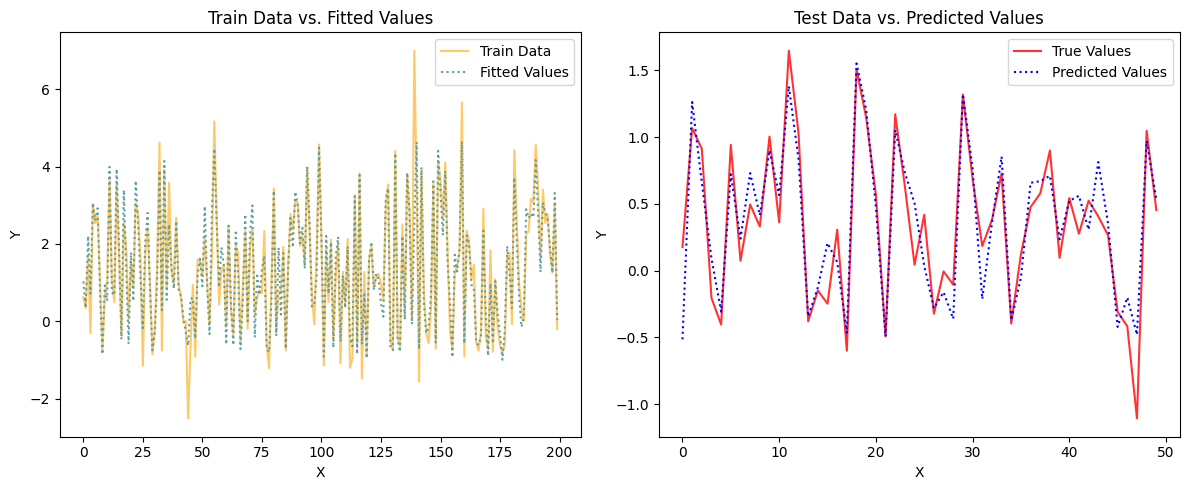

In [18]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot (left side)
axs[0].plot(train_y, label='Train Data', color='orange', alpha=0.6)
axs[0].plot(fitted['fitted'], label='Fitted Values', color='cadetblue', linestyle=':', alpha=1)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Train Data vs. Fitted Values')
axs[0].legend()

# Second subplot (right side)
axs[1].plot(test_y, label='True Values', color='red', alpha=0.8)
axs[1].plot(test_y_predicted, label='Predicted Values', color='blue', linestyle=':')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')
axs[1].set_title('Test Data vs. Predicted Values')
axs[1].legend()

plt.tight_layout() 
plt.show()

By looking at the plot we notice that the predicted values are close to the actual values, as confirmed by the score metrics. From this we can assert that our predict function is working well.

# Section II: Our Model - Final form
After finally building up the model, we put everything together in the following class

In [19]:
class BackfitAdditiveModel(BaseEstimator, RegressorMixin):
    def __init__(self, max_iter=100, tol=1e-6, kernel=rbf.epanechnikov, bandwith=0.2, degree=1):
        self.max_iter = max_iter
        self.tol = tol
        self.kernel = kernel
        self.bandwith = bandwith
        self.degree = degree
    
    def centered_smoothing(self, x, y):
        smoothed_values = localreg(x, y, degree=self.degree, kernel=self.kernel, frac=self.bandwith)
        #xout, smoothed_values, wout = loess_1d.loess_1d(x, y, frac=self.bandwith, degree=self.degree)
        return smoothed_values - np.mean(smoothed_values)
    
    def backfit(self, x, residuals, f):
        # Check inputs
        if x.shape[0] != residuals.shape[0] or x.shape[0] != f.shape[0]:
            raise ValueError("x, residuals, and f must have the same number of rows")
        if len(x.shape) == 1:
            p = 1
        else:
            p = x.shape[1]
            
        residuals_copy = np.copy(residuals)
        # Initialize m with f
        m = np.copy(f)
        # Loop over each dimension
        for j in range(p):
            # Compute partial residuals
            partial_residuals = residuals_copy + f[:, j]
            # Extract column j of x
            x_j = x[:, j].reshape(-1,) if p > 1 else x.reshape(-1, )
            # Perform centered smoothing
            m[:, j] = self.centered_smoothing(x_j, partial_residuals)
            # Update residuals and m in-place
            residuals_copy += (f[:, j] - m[:,j])
        return m
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        # Check inputs
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of rows")
        n, d = X.shape

        # Initialize alpha, residuals and partials
        alpha = np.mean(y)
        residuals = y - alpha

        f = np.zeros((n, d)) # Initialize partials to 0

        rss0 = np.sum(residuals**2)
        # Perform backfitting until convergence
        iteration = 0

        while iteration < self.max_iter:
            # Perform backfitting
            g = self.backfit(X, residuals, f)
            # Compute change in fitted values
            ## Update residuals
            residuals += (np.sum(f, axis=1) - np.sum(g, axis=1))
            rss = np.sum(residuals**2)

            # Check for convergence
            if np.abs(rss - rss0) < (self.tol*rss):
                break
            else:
                rss0 = rss
            # Update f
            f = g
            iteration += 1

        # Compute fitted values
        fitted = alpha + np.sum(f, axis=1)
        
        self.backfit_result = {
            'fitted': fitted,
            'residuals': residuals,
            'mean': alpha,
            'partials': f,
            'x': X,
            'converged': iteration < self.max_iter,
            'iterations': iteration,
            'tol': self.tol
        }
        return self
    
    def predict(self, X):
        newdata = np.array(X)
        backfitted_am = self.backfit_result
        # Check if the number of columns in newdata matches the number of columns in backfitted_am.x
        assert newdata.shape[1] == backfitted_am['x'].shape[1], "Number of columns in newdata must match the number of columns in backfitted_am.x"
        # Initialize predictions
        predictions = np.repeat(backfitted_am['mean'], len(newdata))
        # Get the number of columns in the data
        d = backfitted_am['x'].shape[1]
        # Loop over each column
        for j in range(d):
            # Calculate the partial residuals
            partial_residuals = backfitted_am['residuals'] + backfitted_am['partials'][:, j]
            # Perform local poly regression
            predictions += localreg(backfitted_am['x'][:, j], partial_residuals, x0=newdata[:,j], frac=self.bandwith, degree=self.degree, kernel=self.kernel)

        return predictions


Now we test the class with the same data and parameters as before to make sure everything is working correctly and there are no discrepancies.

In [20]:
np.random.seed(0)
train_size = 200
train_x = np.random.uniform(-2, 2, (train_size, 3))  # 3 features
train_y = np.tanh(train_x[:, 0]) + train_x[:, 1]**2 + 0.3 * np.random.standard_t(df=3, size=train_size)

# Generate synthetic test data
test_size = 50
test_x = np.random.uniform(-1, 1, (test_size, 3))  # 3 features

# Generate synthetic test labels based on the same underlying function
test_y = np.tanh(test_x[:, 0]) + test_x[:, 1]**2 + 0.1 * np.random.standard_t(df=3, size=test_size)

model = BackfitAdditiveModel()
fitted = model.fit(train_x, train_y)
predictions = model.predict(test_x)

print('Iterations to converge:', fitted.backfit_result['iterations'])

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(test_y, predictions)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) coefficient:", r_squared)

Iterations to converge: 7
Mean Absolute Error (MAE): 0.18341002556390495
Mean Squared Error (MSE): 0.05649558696979418
Root Mean Squared Error (RMSE): 0.23768800342001736
R-squared (R²) coefficient: 0.8355385019915054


Indeed, we don't notice any issue, the results are the same as before.

Finally we also take a look at the performance of the fitting method and we notice that the localreg function is what slows down the model training the most.

In [21]:
# Get the profile results
cProfile.run('model.fit(train_x, train_y)', 'output.prof')
p = pstats.Stats('output.prof')
p.sort_stats('cumulative').print_stats(10)  

Mon May 13 15:42:22 2024    output.prof

         528864 function calls in 1.561 seconds

   Ordered by: cumulative time
   List reduced from 71 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.561    1.561 {built-in method builtins.exec}
        1    0.000    0.000    1.561    1.561 <string>:1(<module>)
        1    0.000    0.000    1.561    1.561 /tmp/ipykernel_18/3406708713.py:38(fit)
        8    0.001    0.000    1.560    0.195 /tmp/ipykernel_18/3406708713.py:14(backfit)
       24    0.000    0.000    1.560    0.065 /tmp/ipykernel_18/3406708713.py:9(centered_smoothing)
       24    0.159    0.007    1.558    0.065 /opt/conda/lib/python3.10/site-packages/localreg/localreg.py:86(localreg)
     4800    0.359    0.000    1.095    0.000 /opt/conda/lib/python3.10/site-packages/localreg/localreg.py:35(polyfit)
     4800    0.228    0.000    0.319    0.000 /opt/conda/lib/python3.10/site-packages/numpy/

# Section III: Data of this competition
In the previous cells, we implemented our version of local polynomials within GAM and now we will use them for the data for this homework.

In [22]:
# Load the data
train_data = pd.read_csv("/kaggle/input/statistical-learning-warm-up-hw01-2024/train.csv")
test_data = pd.read_csv("/kaggle/input/statistical-learning-warm-up-hw01-2024/test.csv")

#train_data = pd.read_csv("train.csv")
#test_data = pd.read_csv("test.csv")

### EDA on the data

In [23]:
train_data.head()

,id,ug,gr,ri,iz,zy,i,target
0,1,0.2491,0.5261,0.0211,0.1893,-0.1200,25.0407,0.333786
1,3,0.7974,0.6276,0.6988,0.7596,0.1181,26.2054,0.992741
2,4,1.2463,0.9774,0.4448,0.5389,-72.6299,26.9090,0.510373
3,5,0.3141,0.8543,0.4881,0.7115,-0.3689,26.4756,0.925206
4,7,-0.1624,-0.0273,0.1789,0.7384,0.2606,26.9945,1.021120


In [24]:
train_data.describe()

,id,ug,gr,ri,iz,zy,i,target
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,5004.257333,5.800717,1.073118,0.608266,0.311435,-0.693126,25.281125,0.821112
std,2885.527742,19.238183,4.614295,0.913553,0.355426,8.082184,1.544918,0.415524
min,1.000000,-71.293200,-68.240300,-0.353900,-3.810200,-73.393800,16.528800,0.049498
25%,2502.750000,0.138725,0.452400,0.307650,0.133475,0.021575,24.555600,0.493222
50%,5003.500000,0.551950,0.739250,0.551550,0.288400,0.238450,25.716400,0.742574
75%,7505.250000,1.158550,1.048050,0.814825,0.526250,0.481900,26.456525,1.089282
max,9999.000000,73.436000,71.861800,72.036100,1.921400,3.754900,26.999900,1.997720


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

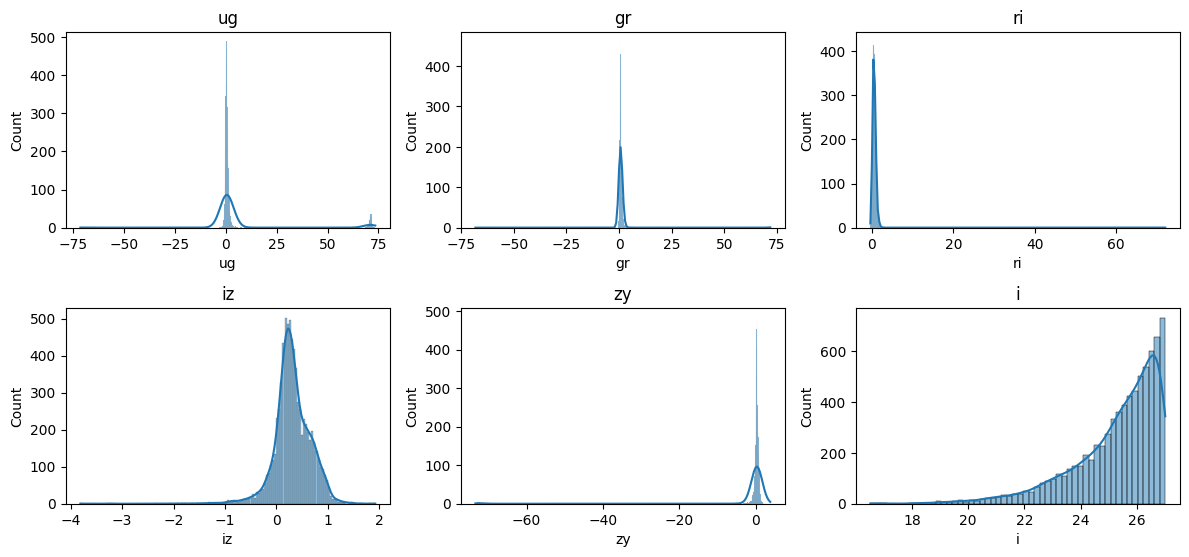

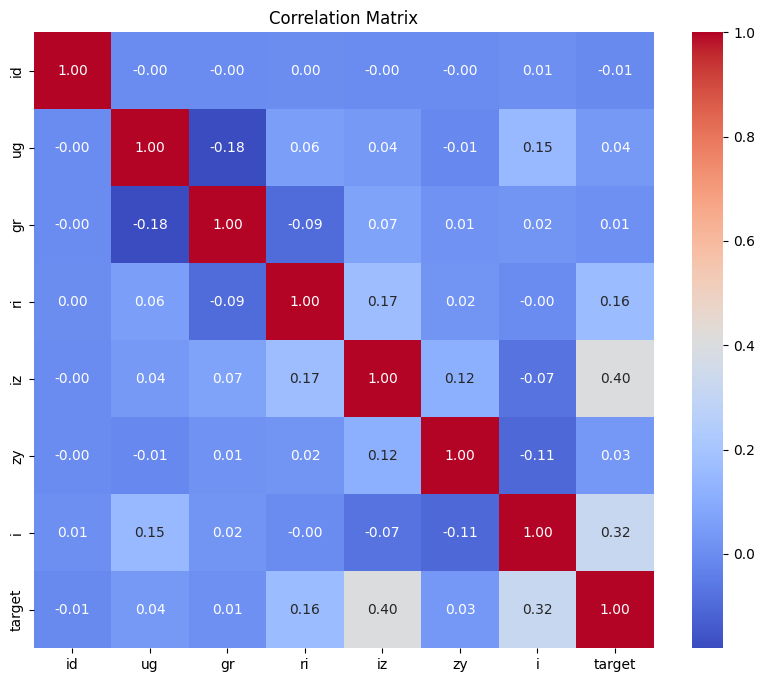

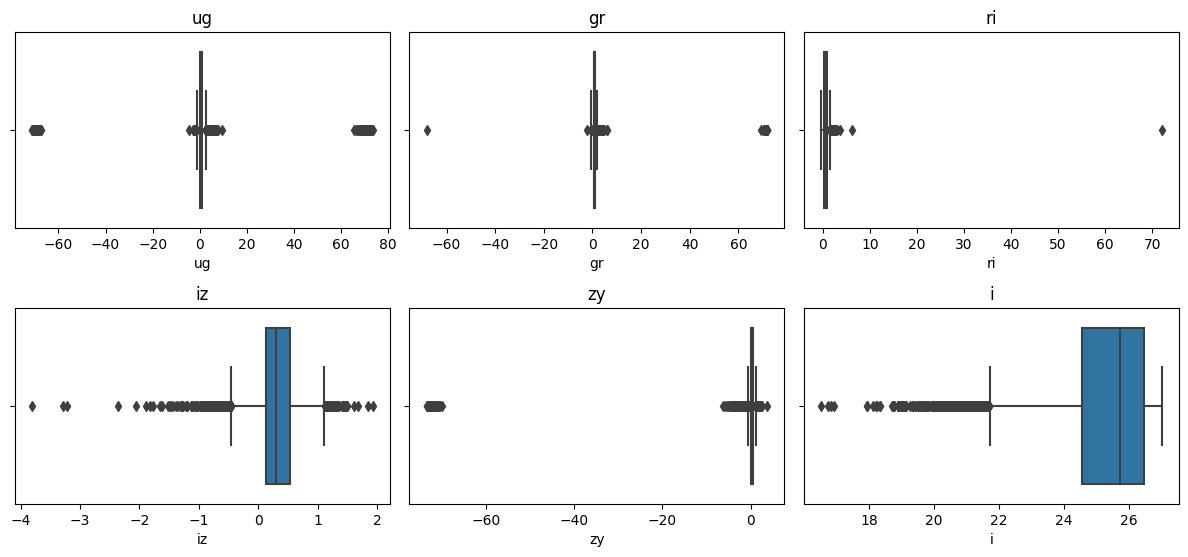

In [25]:
# Data distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_data.columns[1:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(train_data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Outlier detection
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_data.columns[1:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=train_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

We notice that in the data the are some outliers we should remove, as they seem to derive from data entry or processing error.

**Cleaning and pre-processing the Data**

In [26]:
# Extract predictors and target variable
X = train_data[['ug', 'gr', 'ri', 'iz', 'zy', 'i']]
y = train_data['target']

columns_to_fix = ['ug', 'zy', 'gr', 'ri']

# Apply the function only to the specified columns
X_fixed = X.copy() 
for col in columns_to_fix:
    X_fixed[col] = fix_outliers(X[col])

# Scale the variables    
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_fixed)

# Split the training dataset in training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_fixed, y, test_size=0.2, random_state=1)

In [27]:
X_fixed.describe()

,ug,gr,ri,iz,zy,i
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.616165,0.791257,0.597272,0.311435,0.214848,25.281125
std,0.844493,0.519035,0.384824,0.355426,0.560321,1.544918
min,-4.643000,-2.350800,-0.353900,-3.810200,-6.284700,16.528800
25%,0.123250,0.450575,0.307500,0.133475,0.035100,24.555600
50%,0.505000,0.735950,0.551450,0.288400,0.241700,25.716400
75%,0.949113,1.041575,0.813925,0.526250,0.484425,26.456525
max,9.331700,5.799400,2.730500,1.921400,3.754900,26.999900


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

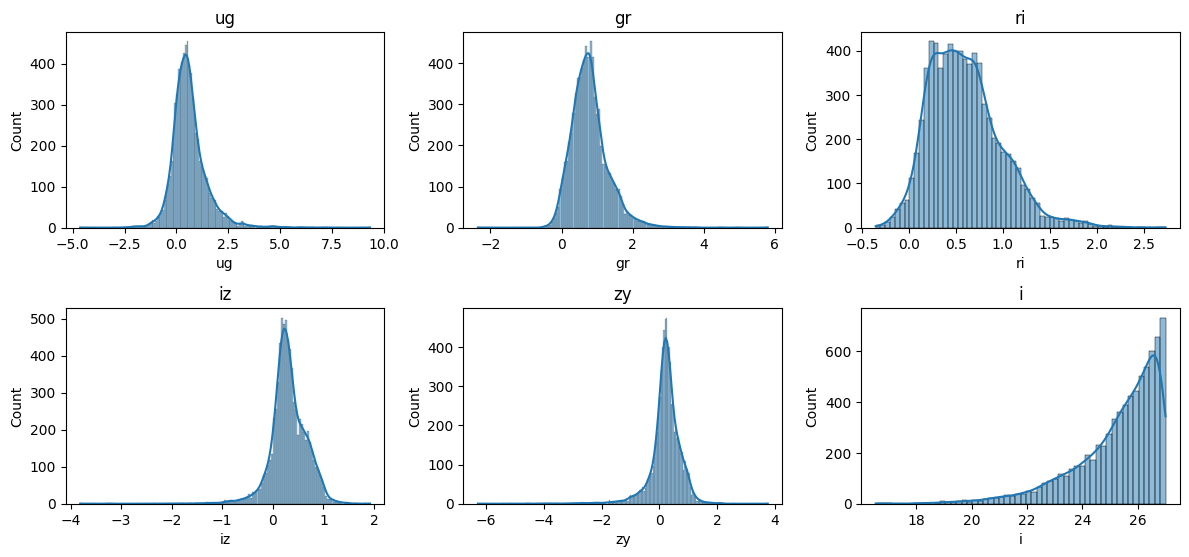

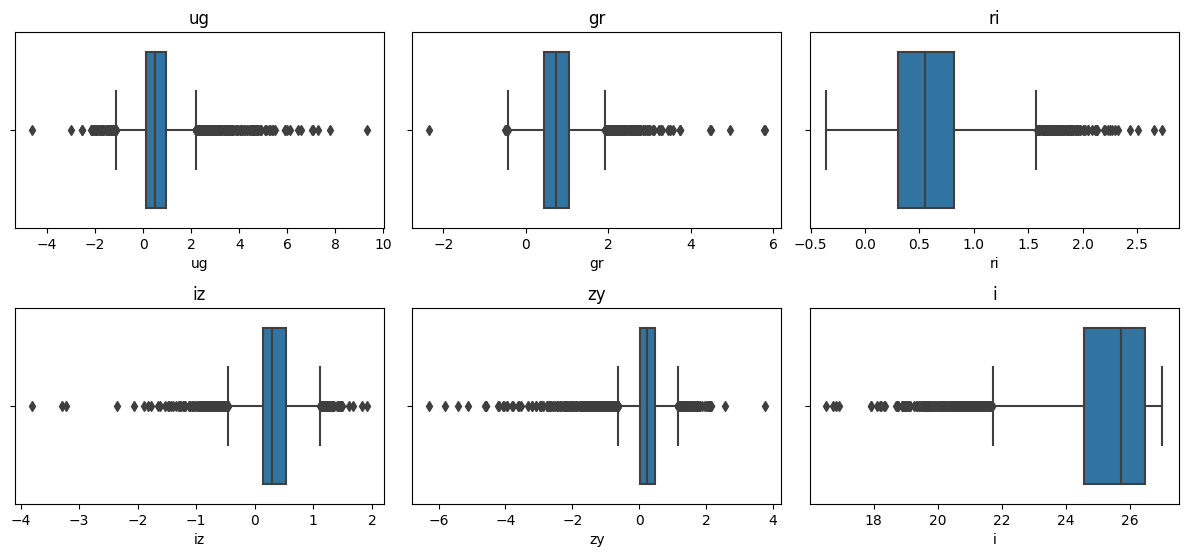

In [28]:
# Data distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_fixed.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_fixed[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Outlier detection
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_fixed.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=X_fixed[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Training and prediction

We now try to use our class to fit and predict the competition data

In [29]:
# Create an instance of the model
model = BackfitAdditiveModel(tol=1e-3, max_iter=50, bandwith=0.15, degree=1, kernel=rbf.triweight)
# Fit the model
fitted = model.fit(X_train, y_train)
# Predict using the fitted model
predictions = model.predict(X_val)

In [30]:
print('Iterations to converge:', fitted.backfit_result['iterations'])

# Evaluate the model
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) coefficient:", r2)
print("Root Mean Squared Error:",mse**0.5)

Iterations to converge: 4

Evaluation Metrics:
Mean Squared Error (MSE): 0.07695356423181123
Mean Absolute Error (MAE): 0.19062471962790384
R-squared (R²) coefficient: 0.561401102483702
Root Mean Squared Error: 0.2774050544453205


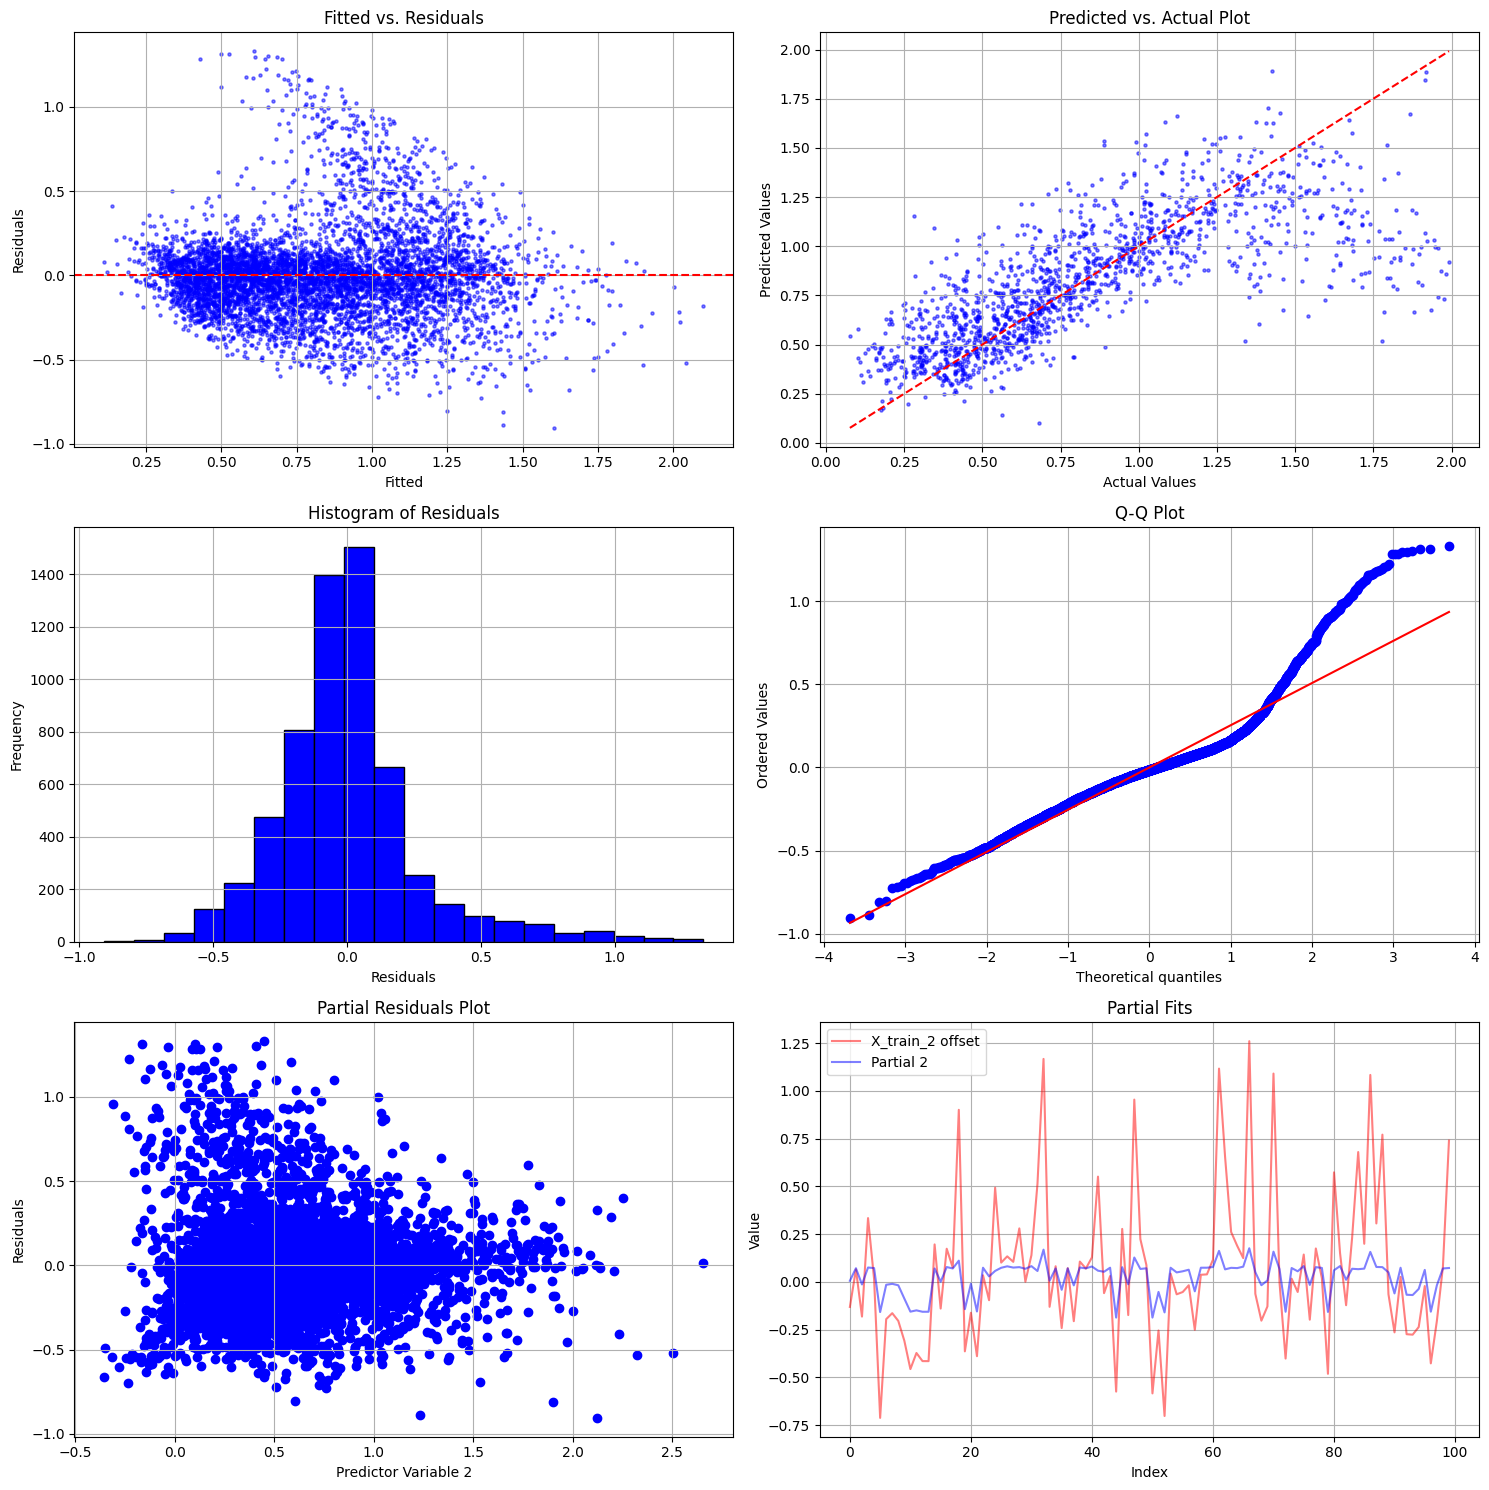

In [31]:
# Example usage:
diagnostic_plots(fitted.backfit_result, y_val, predictions, X_train, 2, range(100, 200))

The results are enocuraging, however it is clear that the model is not able to capture all the variance in the data and in particular fails to correctly predict the higher values. Indeed, the residuals distribution has fat right tails and the Q-Q plot indicates the same. Moreover the residuals seem to have a particular shape and to not be completely randomly distributed around zero. However, we can also see that the partials are quite able to track the shape of the data, which is a good sign.

# Section IV: Cross Validation


Now we can use our class to perform cross validation. In particular, since we built a model class we will make use of already implemented functions in the hope to speed up the computation. We want to try so select the best kernel, bandwith $h$ and degree of the polynomial $d$. In particular for $d$ we are only interested in three possible values $\{0, 1, 3\}$.

**CV Version 1: GridSearch**

We start with a classic grid search cross validation using the `GridSearchCV` object. We will use the following values for the parameters:
- kernel: rbf.epanechnikov - since it is neither too peaked nor too spread
- h: 0.1, 0.2, 0.3
- d: 0, 1, 3

We will perform a 5 fold Cross Validation

In [32]:
# Create a pipeline with BackfitAdditiveModel
pipeline = Pipeline([('backfit', BackfitAdditiveModel(tol=1e-3, max_iter=50))])

# Define parameter grid for GridSearchCV
param_grid = {
    'backfit__kernel': [rbf.epanechnikov],
    'backfit__bandwith': [0.1, 0.2, 0.3],
    'backfit__degree': [0, 1, 3]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Use MSE as scoring metric
                           cv=5,  # 5-fold cross-validation
                           verbose=1,  # Print progress
                           n_jobs=-1)  # Use all available CPU cores

In [33]:
grid_search.fit(X_fixed, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('backfit',
                                        BackfitAdditiveModel(max_iter=50,
                                                             tol=0.001))]),
             n_jobs=-1,
             param_grid={'backfit__bandwith': [0.1, 0.2, 0.3],
                         'backfit__degree': [0, 1, 3],
                         'backfit__kernel': [<function epanechnikov at 0x7fb0cbb86ef0>]},
             scoring='neg_mean_squared_error', verbose=1)

We now print the results of the grid search

In [34]:
grid_params = grid_search.best_params_
grid_score = grid_search.best_score_
print(grid_params, grid_score)

{'backfit__bandwith': 0.2, 'backfit__degree': 1, 'backfit__kernel': <function epanechnikov at 0x7fb0cbb86ef0>} -0.07357857632410061


In [35]:
model = BackfitAdditiveModel(max_iter=100, tol=1e-6, kernel=grid_params['backfit__kernel'], bandwith=grid_params['backfit__bandwith'], degree=grid_params['backfit__degree'])
fitted = model.fit(X_train, y_train)
best_y_pred = model.predict(X_val)
# Evaluate the model
mse = mean_squared_error(y_val, best_y_pred)
mae = mean_absolute_error(y_val, best_y_pred)
r2 = r2_score(y_val, best_y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) coefficient:", r2)
print("Root Mean Squared Error:",mse**0.5)


Evaluation Metrics:
Mean Squared Error (MSE): 0.0782724659517229
Mean Absolute Error (MAE): 0.19134998371813755
R-squared (R²) coefficient: 0.5538839868561132
Root Mean Squared Error: 0.27977216793620285


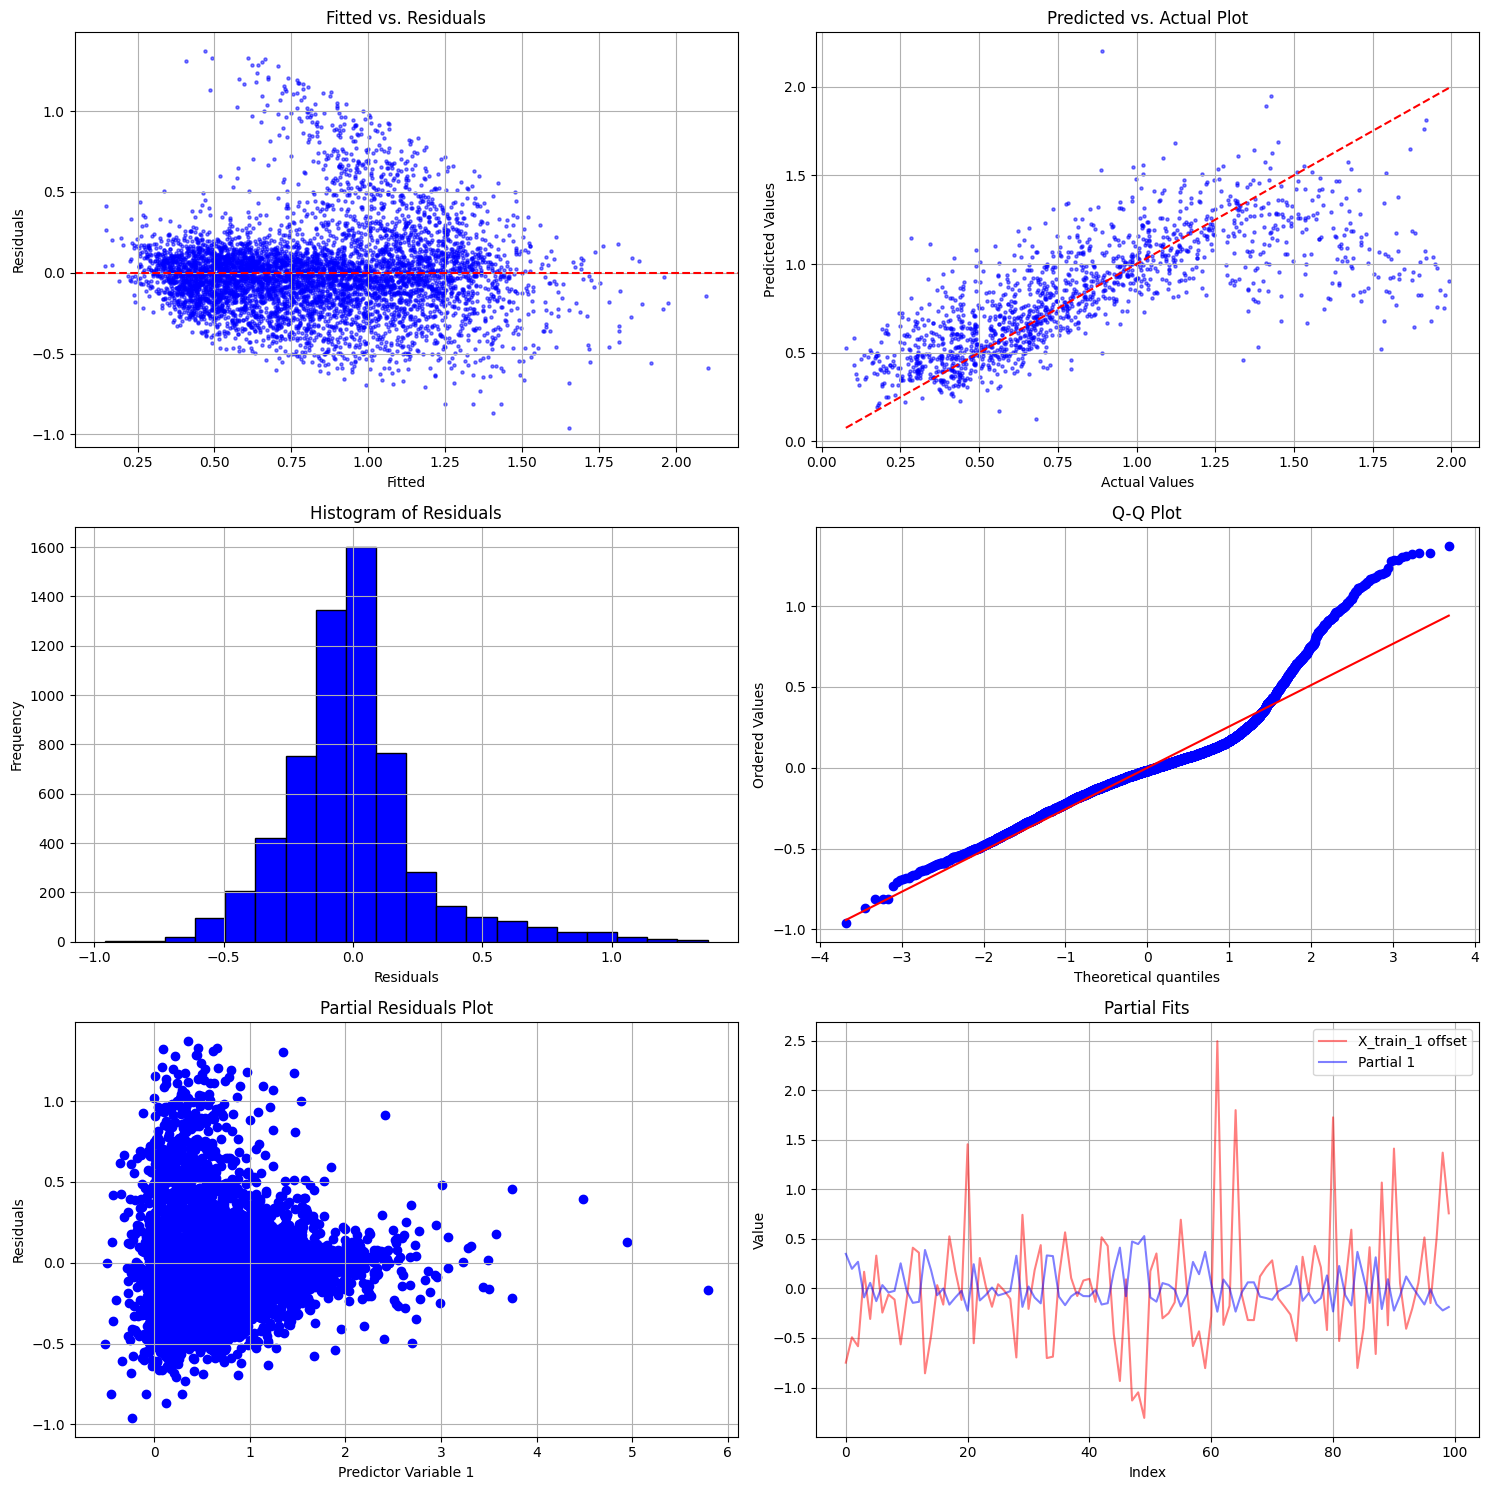

In [36]:
diagnostic_plots(fitted.backfit_result, y_val, best_y_pred, X_train, 1,  range(1000, 1100))

**CV Version 2: Bayes Search**

We would like to perform a more exhaustive search, but this would take too much time with GridSearchCV, thus we exploit `BayesSearchCV` that should be a more efficient and performing solution. In particular now we include more kernels and extend the possible range of $h$ values from $0.05$ to $0.5$.

In [37]:
# Create a pipeline with BackfitAdditiveModel
pipeline = Pipeline([('backfit', BackfitAdditiveModel(tol=1e-3, max_iter=50))])

# Define the search space for each hyperparameter
search_spaces = {
    'backfit__kernel': Categorical([rbf.epanechnikov, rbf.gaussian, rbf.triweight]),
    'backfit__bandwith': Real(0.05, 0.5, prior='uniform'),
    'backfit__degree': Categorical([0, 1, 3])
}

# Create BayesSearchCV object
bayes_search = BayesSearchCV(estimator=pipeline,
                             search_spaces=search_spaces,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             verbose=1,
                             n_jobs=-1,
                             n_iter=10)

In [38]:
# Fitting bayes search cv on our training data
bayes_search.fit(X_fixed, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('backfit',
                                         BackfitAdditiveModel(max_iter=50,
                                                              tol=0.001))]),
              n_iter=10, n_jobs=-1, scoring='neg_mean_squared_error',
              search_spaces={'backfit__bandwith': Real(low=0.05, high=0.5, prior='uniform', transform='normalize'),
                             'backfit__degree': Categorical(categories=(0, 1, 3), prior=None),
                             'backfit__kernel': Categorical(categories=(<function epanechnikov at 0x7fb0cbb86ef0>, <function gaussian at 0x7fb0cbb87130>, <function triweight at 0x7fb0cbb87010>), prior=None)},
              verbose=1)

In [39]:
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_

print("Best parameters:", best_params)
print("Best score (MSE):", best_score)

Best parameters: OrderedDict([('backfit__bandwith', 0.2521845815892711), ('backfit__degree', 1), ('backfit__kernel', <function triweight at 0x7fb0cbb87010>)])
Best score (MSE): 0.07335185839864325


In [40]:
model = BackfitAdditiveModel(max_iter=100, tol=1e-6, kernel=best_params['backfit__kernel'], bandwith=best_params['backfit__bandwith'], degree=best_params['backfit__degree'])
fitted = model.fit(X_train, y_train)
best_y_pred = model.predict(X_val)
# Evaluate the model
mse = mean_squared_error(y_val, best_y_pred)
mae = mean_absolute_error(y_val, best_y_pred)
r2 = r2_score(y_val, best_y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) coefficient:", r2)
print("Root Mean Squared Error:",mse**0.5)


Evaluation Metrics:
Mean Squared Error (MSE): 0.07754475231659239
Mean Absolute Error (MAE): 0.19111164388278348
R-squared (R²) coefficient: 0.5580316101827515
Root Mean Squared Error: 0.27846858407474334


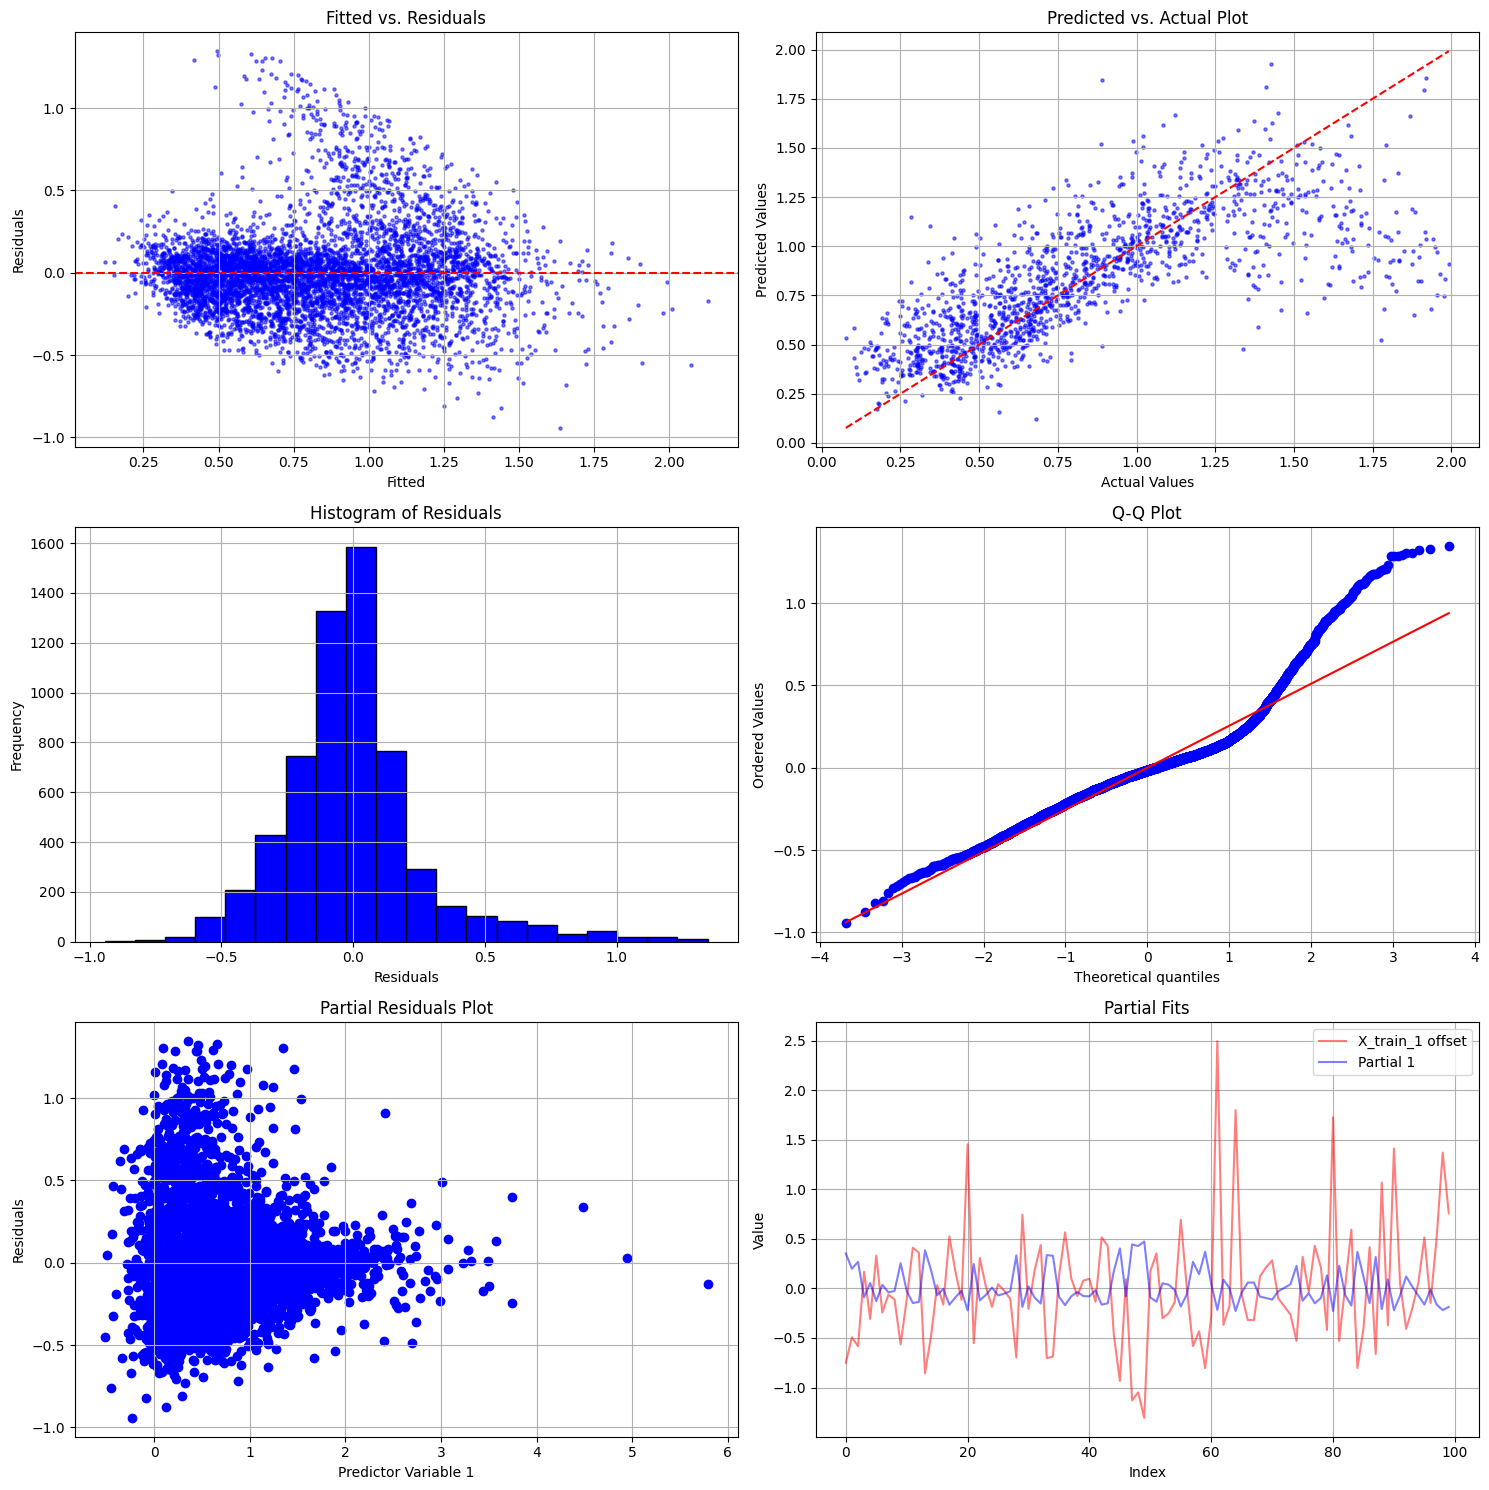

In [41]:
diagnostic_plots(fitted.backfit_result, y_val, best_y_pred, X_train, 1,  range(1000, 1100))

### Prediction on test data

In [42]:
test=test_data[['ug', 'gr', 'ri', 'iz', 'zy', 'i']]

In [43]:
test.describe()

,ug,gr,ri,iz,zy,i
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,6.158377,1.102247,0.592318,0.279556,-0.523172,25.280065
std,19.934545,4.676008,0.379432,1.487281,7.642625,1.541801
min,-70.784200,-0.745200,-0.466000,-72.102500,-72.758500,16.798300
25%,0.135450,0.453700,0.305950,0.126975,0.041625,24.528150
50%,0.522250,0.734800,0.547700,0.283650,0.248850,25.706450
75%,1.081025,1.037900,0.825000,0.500075,0.485700,26.469100
max,72.850400,71.430600,2.514800,1.719100,72.133600,26.999800


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

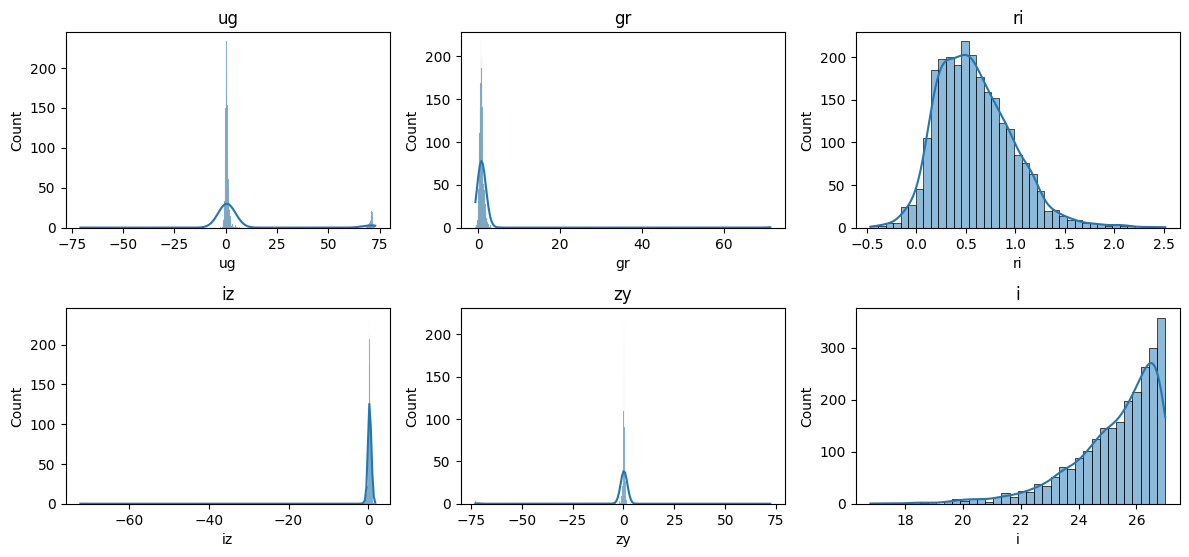

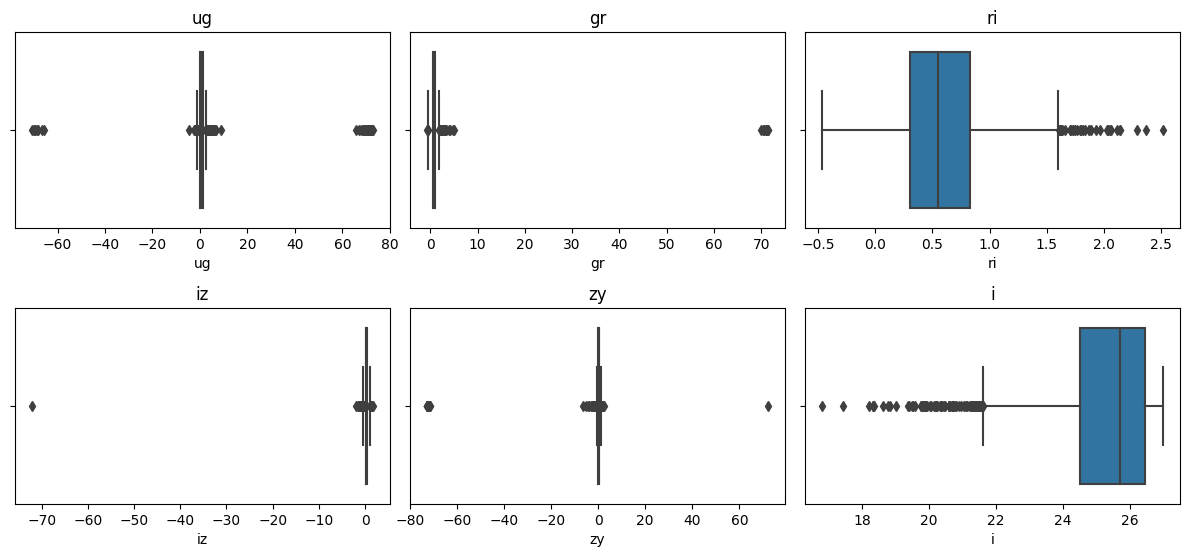

In [44]:
# Data distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(test.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(test[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Outlier detection
plt.figure(figsize=(12, 8))
for i, col in enumerate(test.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=test[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Since the test data too shows some outliers, we thought it best to fix them too.

In [45]:
columns_to_fix = ['ug', 'zy', 'gr', 'iz']

# Apply the function only to the specified columns
test_fixed = test.copy() 
for col in columns_to_fix:
    test_fixed[col] = fix_outliers(test[col])


# Standardize the features
#test_scaled = scaler.fit_transform(test_fixed)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

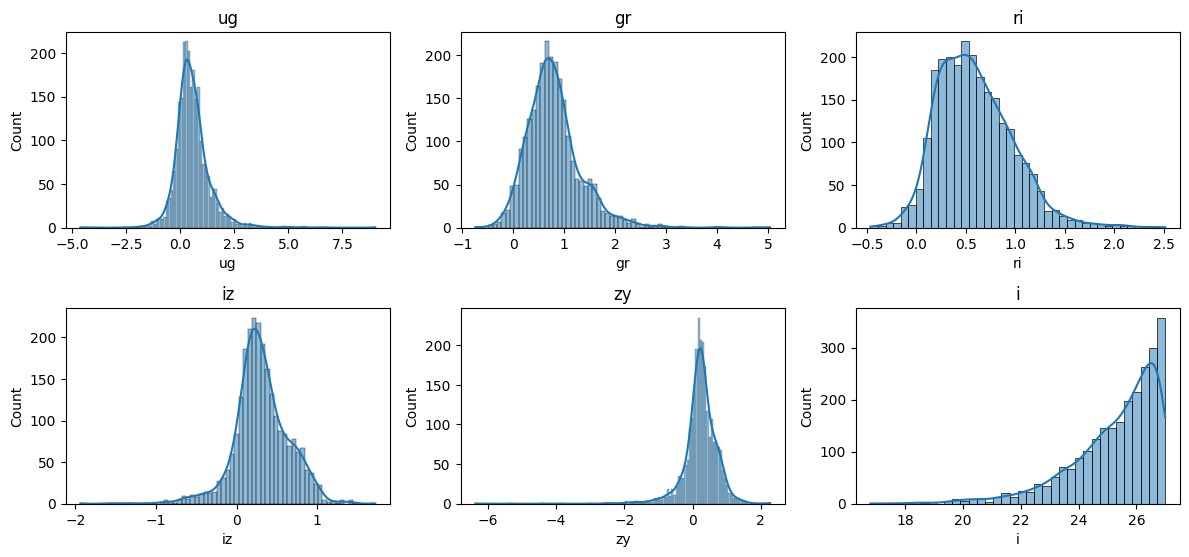

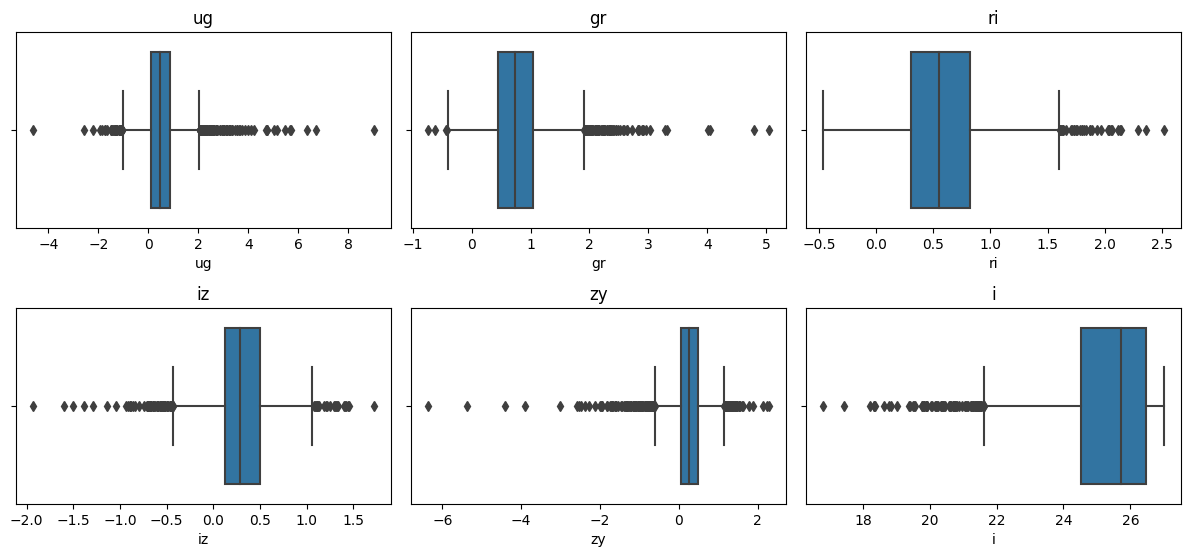

In [46]:
# Data distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(test_fixed.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(test_fixed[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Outlier detection
plt.figure(figsize=(12, 8))
for i, col in enumerate(test_fixed.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=test_fixed[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Now we train the two models with the parameters obtained by the two CV strategies and use them to predict the test data.

In [47]:
# Train and predict with BayesSearchCv params
model_bayes = BackfitAdditiveModel(max_iter=100, tol=1e-6, kernel=best_params['backfit__kernel'], bandwith=best_params['backfit__bandwith'], degree=best_params['backfit__degree'])
fitted_bayes = model_bayes.fit(X_fixed, y)
predictions_bayes = model_bayes.predict(test_fixed)

# Train and predict with GridSearchCv params
model_grid = BackfitAdditiveModel(max_iter=100, tol=1e-6, kernel=grid_params['backfit__kernel'], bandwith=grid_params['backfit__bandwith'], degree=grid_params['backfit__degree'])
fitted_grid = model_grid.fit(X_fixed, y)
predictions_grid = model_grid.predict(test_fixed)

# Section V: Predictor Importance

In this section we will implement 2 techniques to measure predictor importance: LOCO and PFI. We will then use them to understand which predictors are the most important in our model.

## LOCO - Leave One Covariate Out

LOCO is an essentially assumptions–free idea for measuring variable importance. The idea is to measure the change in the model's performance when a single predictor is removed from the model. The change in performance is then used as a measure of the importance of the predictor. The LOCO score is defined as the median difference between the performance of the model with all predictors and the performance of the model with the predictor of interest removed. The LOCO score for a variable also has a very clear intepretations as it is just how much extra prediction error we would pay by not having access to the variable $X_j$.
 
We implement the algorithm to compute the scores, as well as a non-parametric bootstrap estimation of the confidence intervals for this statistic. Finally, we adjust for mulitplicity applying Bonferroni correction.

In [48]:
def compute_loco(X, y, test_size, model, num_bootstraps):
    # Randomly split data into two parts
    D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=test_size, random_state=1)
    
    # Train model on first part
    full_model = model.fit(D1_X, D1_y)
    pred_fn1 = full_model.predict(D2_X)
    
    thetas = {}
    conf_ints = []
    for j in range(X.shape[1]):
        # Recompute model without variable X[j] on first part
        D1_X_no_j = np.delete(D1_X, j, axis=1)
        model_no_j = model.fit(D1_X_no_j, D1_y)

        # Compute predictions on second part
        pred_fn1_noj = model_no_j.predict(np.delete(D2_X, j, axis=1))

        # Compute error differences
        loss_fn1 = np.abs(D2_y - pred_fn1)
        loss_fn1_noj = np.abs(D2_y - pred_fn1_noj)
        
        error_diff = loss_fn1_noj - loss_fn1

        median_j = np.median(error_diff)
        thetas[j+1] = median_j

        # Initialize array to store bootstrap statistics
        bootstrap_statistics = []

        # Perform bootstrap resampling
        for _ in range(num_bootstraps):
            # Sample with replacement
            bootstrap_before = np.random.choice(loss_fn1, size=len(loss_fn1), replace=True)
            bootstrap_after = np.random.choice(loss_fn1_noj, size=len(loss_fn1_noj), replace=True)

            # Compute statistic of interest for the bootstrap sample
            bootstrap_difference = np.median(np.abs(bootstrap_before - bootstrap_after))

            # Store bootstrap statistic
            bootstrap_statistics.append(bootstrap_difference)

        # Calculate confidence interval from bootstrap statistics
        sd_err = np.std(bootstrap_statistics)
        # Apply Bonferroni correction to adjust confidence interval
        alpha = 0.05  # Desired family-wise error rate
        num_tests = X.shape[1]  # Number of tests (number of covariates)
        bonferroni_alpha = alpha / num_tests
        z = -norm.ppf(bonferroni_alpha)
        
        # Compute adjusted conf ints
        adjusted_confidence_interval = (median_j - z * sd_err, median_j + z * sd_err )
        conf_ints.append(adjusted_confidence_interval)
        
    
    return thetas, conf_ints

In [49]:
def rescale_confidence_intervals(confidence_intervals, loco_scores_sum):
    return confidence_intervals / loco_scores_sum

def rescale_loco_scores_and_confidence_intervals(loco_scores, confidence_intervals):
    loco_scores_sum = sum(loco_scores.values())
    rescaled_scores = {key: score / loco_scores_sum for key, score in loco_scores.items()}
    rescaled_confidence_intervals = rescale_confidence_intervals(confidence_intervals, loco_scores_sum)
    return rescaled_scores, rescaled_confidence_intervals

### Toy example 1

We construct a toy example to understand if the algorithm is correct.

In [50]:
np.random.seed(2)
a = np.random.uniform(-2, 2, 200)
b = np.random.uniform(-0.01, 0.01, 200)
x = np.column_stack((a, b, np.random.exponential(scale=3, size=200)))
y = np.sin(x[:, 0]) + x[:, 1] + x[:, 2] + 0.1*np.random.standard_t(df=3, size=200)

thetas, confidence_intervals  = compute_loco(x, y, 0.2, BackfitAdditiveModel(), 200)
sorted_thetas = sorted(thetas, key=thetas.get, reverse=True)
print(thetas)
print('Sorted thetas:', sorted_thetas)

{1: 0.70375951323926, 2: -0.009613769285376605, 3: 1.3986854852735386}
Sorted thetas: [3, 1, 2]


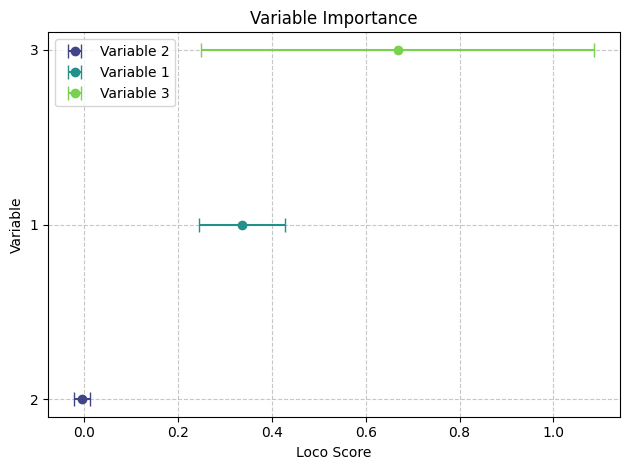

In [51]:
# Rescale LOCO scores and confidence intervals
thetas, confidence_intervals = rescale_loco_scores_and_confidence_intervals(thetas, confidence_intervals)

statistics = np.array(list(thetas.values()))
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))

# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=f'Variable {sorted_indices[i]+1}')
plt.title('Variable Importance')
plt.xlabel('Loco Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), sorted_indices + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The algorithm assigns great importance to the first and third variables, while the second one is considered pretty much irrelevant, which makes sense given that it is just a random uniform with very low values. We rescale the values to make them more interpretable. Then, LOCO scores tell us, for example, that we would pay an increased $60\%$ prediciton error by not having access to variable $3$.

### Toy example 2

We construct another toy example to understand better the behaviour of the algorithm. In particular, we create two variable perfectly correlated and we pass them to the model. We expect that the LOCO score for the two variables is the same, as they are perfectly correlated and thus the model should not be able to distinguish between them.

In [52]:
np.random.seed(2)
a = np.random.uniform(-2, 2, 200)
b = a + np.random.uniform(-0.1, 0.1, 200)
x = np.column_stack((a, b, np.random.exponential(scale=2, size=200)))
y = x[:, 0] + x[:, 1] + x[:, 2] + 0.3*np.random.standard_t(df=3, size=200)

thetas, confidence_intervals  = compute_loco(x, y, 0.2, BackfitAdditiveModel(), 1000)
sorted_thetas = sorted(thetas, key=thetas.get, reverse=True)
print(thetas)
print('Sorted thetas:', sorted_thetas)

{1: -0.0015184466065500946, 2: -0.0032756333851760022, 3: 0.9785881332001656}
Sorted thetas: [3, 1, 2]


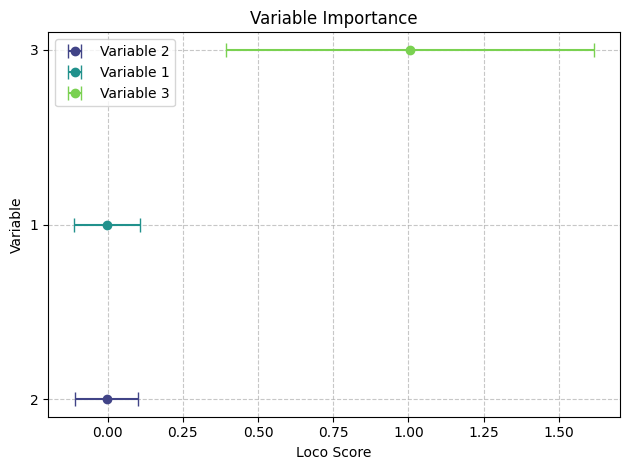

In [53]:
thetas, confidence_intervals = rescale_loco_scores_and_confidence_intervals(thetas, confidence_intervals)

statistics = np.array(list(thetas.values()))
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))

# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=f'Variable {sorted_indices[i]+1}')
plt.title('Variable Importance')
plt.xlabel('Loco Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), sorted_indices + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Indeeed, this is what happens. LOCO scores are telling us that $X_1$ and $X_2$ can basically take each others place if one of them is left out. The scores provide us insight into whether the model requires acces to a specific $X_j$. However, this also constitutes a problem becuase the algorithm assigns to both of them a score equal to zero, thus we understand we have to be careful when dealing with LOCO scores of correlated variables.

Now, we try to remove one of the two variables and we expect the LOCO score for the variable left to increase significantly.

In [54]:
np.random.seed(2)
a = np.random.uniform(-2, 2, 200)
b = a + np.random.uniform(-0.1, 0.1, 200)
x = np.column_stack((a, np.random.exponential(scale=2, size=200)))
y = x[:, 0] + x[:, 1] + 0.3*np.random.standard_t(df=3, size=200)

thetas, confidence_intervals  = compute_loco(x, y, 0.2, BackfitAdditiveModel(), 1000)
sorted_thetas = sorted(thetas, key=thetas.get, reverse=True)
print(thetas)
print('Sorted thetas:', sorted_thetas)

{1: 0.6452920722667588, 2: 0.9508990071180526}
Sorted thetas: [2, 1]


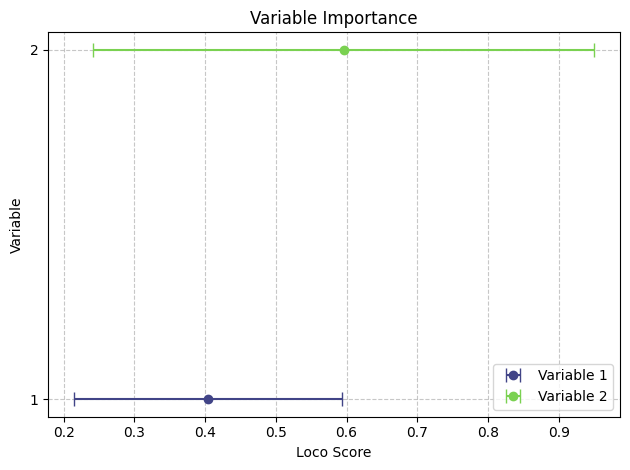

In [55]:
thetas, confidence_intervals = rescale_loco_scores_and_confidence_intervals(thetas, confidence_intervals)

statistics = np.array(list(thetas.values()))
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))

# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=f'Variable {sorted_indices[i]+1}')
plt.title('Variable Importance')
plt.xlabel('Loco Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), sorted_indices + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Indeed, this is what happens.

### Real data

Now we apply the LOCO scores to the real data.

In [56]:
thetas, confidence_intervals = compute_loco(X_train, y_train, 0.2, BackfitAdditiveModel(tol=0.001, max_iter=50, kernel=rbf.triweight, degree=1, bandwith=0.25), 1000)
sorted_thetas = sorted(thetas, key=thetas.get, reverse=True)
print(thetas)
print(sorted_thetas)

{1: 0.0002768940060078051, 2: 0.025532058711610628, 3: 0.012617794427023543, 4: 0.03171041840401739, 5: 0.010724088155044775, 6: -0.0006444574962085059}
[4, 2, 3, 5, 1, 6]


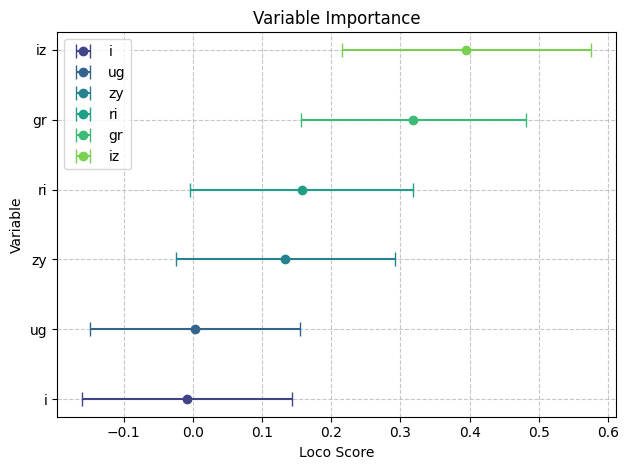

In [57]:
# Rescale LOCO scores and confidence intervals
thetas, confidence_intervals = rescale_loco_scores_and_confidence_intervals(thetas, confidence_intervals)

column_names = X.columns
# Dictionary mapping column indices to column names
column_index_to_name = {i+1: name for i, name in enumerate(column_names)}
statistics = np.array(list(thetas.values()))
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))
# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=column_index_to_name[sorted_indices[i]+1])
plt.title('Variable Importance')
plt.xlabel('Loco Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), [column_index_to_name[index+1] for index in sorted_indices])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

According to LOCO scores the variables `ug` and `i` are pretty much irrelevant for the model, while the most important ones seem to be `iz` and `gr` and also `ri` and `zy` are quite important. The scores tell us that we would pay an increased $40\%$ prediction error by not having access to variable `iz`.

## PFI - Permuted Feature Importance

The idea for PFI is that when we permute the values of feature  $j$, its explanatory power diminishes as it disrupts the association with the outcome variable $y$. Consequently, if the model heavily relies on feature $j$, the prediction error $L(y, f(X))$ of the model should increase when predicting with the "permuted feature" dataset $X_{perm}$ instead of with the "initial feature" dataset $X$. The main advantage of PFI is that we don't need to refit the model $j$ times, but only make $j$ different predictions.

#### By hand implementation

In [58]:
def compute_pfi(X, y, test_size, model, num_permutations, num_bootstraps):
    # Randomly split data into two parts
    D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=test_size, random_state=1)
    
    # Train model on first part
    model = model.fit(D1_X, D1_y)
    pred_f = model.predict(D2_X)  # Baseline performance
    loss_f = np.abs(D2_y - pred_f)

    pfi_scores = {}
    conf_ints = {}
    for j in range(X.shape[1]):
        pfi_scores[j+1] = []  # Initialize list to store PFI scores for this feature
        conf_ints[j+1] = []

        for _ in range(num_permutations):
            # Create copy of feature matrix with permuted feature j
            D2_X_permuted = np.copy(D2_X)
            np.random.shuffle(D2_X_permuted[:, j])  # Permute feature j


            # Compute performance on second part
            pred_f_perm = model.predict(D2_X_permuted)
            loss_f_perm = np.abs(D2_y - pred_f_perm)

            # Compute PFI score and store in the list
            pfi_score = np.mean(loss_f_perm - loss_f)
            pfi_scores[j+1].append(pfi_score)

            # Calculate confidence interval from PFI scores
            bootstrap_statistics = []
    
            for _ in range(num_bootstraps):
                # Sample with replacement
                bootstrap_before = np.random.choice(loss_f, size=len(loss_f), replace=True)
                bootstrap_after = np.random.choice(loss_f_perm, size=len(loss_f_perm), replace=True)
                
                # Compute statistic of interest for the bootstrap sample
                bootstrap_diff = np.mean(bootstrap_after - bootstrap_before)
                # Store bootstrap statistic
                bootstrap_statistics.append(bootstrap_diff)
    
            # Calculate confidence interval from bootstrap statistics
            sd_err = np.std(bootstrap_statistics)
            # Bonferroni correction
            alpha = 0.05
            num_tests = X.shape[1]
            bonferroni_alpha = alpha / num_tests
            z = -norm.ppf(bonferroni_alpha)
            confidence_interval = (pfi_score - z * sd_err, pfi_score + z * sd_err)
            conf_ints[j+1].append(confidence_interval)
        
    pfi_means = {key: np.mean(values) for key, values in pfi_scores.items()}
    pfi_mean_conf_ints = {
    key: (np.mean([tup[0] for tup in values]), np.mean([tup[1] for tup in values]))
    for key, values in conf_ints.items()}
    
    return pfi_means, list(pfi_mean_conf_ints.values())


#### Toy example

In [59]:
np.random.seed(2)
a = np.random.uniform(-2, 2, 200)
b = np.random.uniform(-0.1, 0.1, 200)
x = np.column_stack((a, b, np.random.exponential(scale=2, size=200)))
y = x[:, 0] + x[:, 1] + x[:, 2] + 0.3*np.random.standard_t(df=3, size=200)

thetas, confidence_intervals  = compute_pfi(x, y, 0.3, BackfitAdditiveModel(), 15, 100)
sorted_thetas = sorted(thetas, key=thetas.get, reverse=True)
print(thetas)
print('Sorted thetas:', sorted_thetas)

{1: 0.9513620599114194, 2: -0.0015763656288769981, 3: 2.1647562322251477}
Sorted thetas: [3, 1, 2]


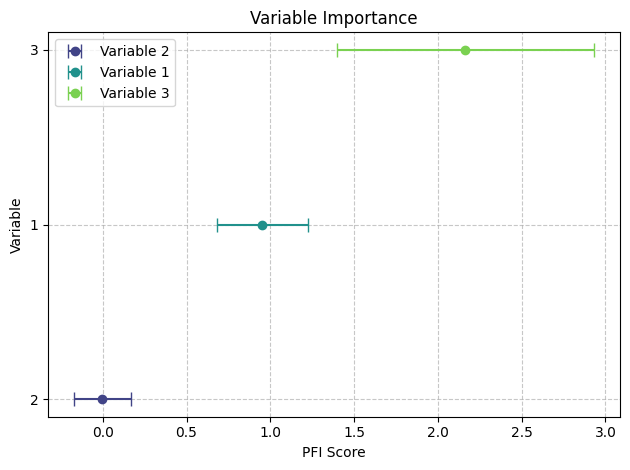

In [60]:
statistics = np.array(list(thetas.values()))
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))

# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=f'Variable {sorted_indices[i]+1}')
plt.title('Variable Importance')
plt.xlabel('PFI Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), sorted_indices + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

As with the LOCO scores the second variable is considered irrelevant.
Our version implemented by hand seems to be able to capture the importance of the features. We decided to compare the results to the ones given by an official library to compute the PFI score.

In [61]:
def compute_pfi_v2(model, X_val, y_val, n_repeats):
    r =  permutation_importance(model, X_val, y_val, n_repeats=n_repeats, random_state=0)
    thetas = r['importances_mean']
    confidence_intervals = []
    z_score = 1.96
    sample_size = D1_X.shape[1]
    for mean, std in zip(thetas,r['importances_std']):
        ci = z_score * (std / np.sqrt(sample_size))
        confidence_intervals.append((mean - ci, mean + ci))
    return thetas, confidence_intervals

In [62]:
D1_X, D2_X, D1_y, D2_y = train_test_split(x, y, test_size=0.2, random_state=1)
model = BackfitAdditiveModel(tol=0.001, max_iter=50).fit(D1_X, D1_y)


thetas, confidence_intervals = compute_pfi_v2(model, D2_X, D2_y, 5)

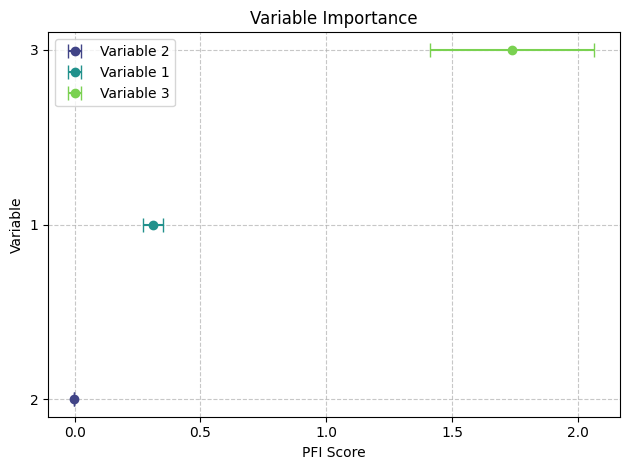

In [63]:
statistics = np.array(thetas)
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))

# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=f'Variable {sorted_indices[i]+1}')
plt.title('Variable Importance')
plt.xlabel('PFI Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), sorted_indices + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The scores pretty much agree, thus we will use the library version since it might be more stable and efficient.

#### Real data

In [64]:
model = BackfitAdditiveModel(tol=0.001, max_iter=50, kernel=rbf.triweight, degree=1, bandwith=0.25).fit(X_train, y_train)
thetas, confidence_intervals = compute_pfi_v2(model, X_val, y_val, 10)

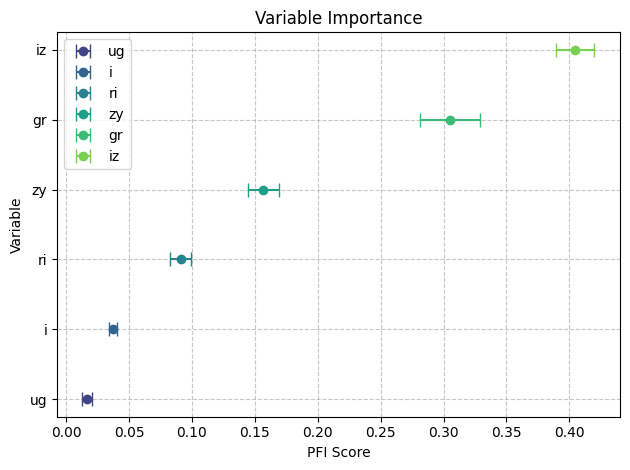

In [65]:
column_names = X.columns

# Dictionary mapping column indices to column names
column_index_to_name = {i+1: name for i, name in enumerate(column_names)}
statistics = np.array(thetas)
confidence_intervals = np.array(confidence_intervals)

# Sort statistics and confidence intervals by statistic values
sorted_indices = np.argsort(statistics)
sorted_statistics = statistics[sorted_indices]
sorted_confidence_intervals = confidence_intervals[sorted_indices]

# Extract lower and upper bounds of confidence intervals
lower_bounds = sorted_confidence_intervals[:, 0]
upper_bounds = sorted_confidence_intervals[:, 1]

# Compute error bars
errors = np.array([sorted_statistics - lower_bounds, upper_bounds - sorted_statistics])

# Define colors for error bars
color_map = plt.cm.viridis(np.linspace(0.2, 0.8, len(statistics)))
# Plot
for i, (stat, err, color) in enumerate(zip(sorted_statistics, errors.T, color_map)):
    plt.errorbar(stat, i, xerr=err[:, None], fmt='o', color=color, ecolor=color, capsize=5, label=column_index_to_name[sorted_indices[i]+1])
plt.title('Variable Importance')
plt.xlabel('PFI Score')
plt.ylabel('Variable')
plt.yticks(np.arange(len(statistics)), [column_index_to_name[index+1] for index in sorted_indices])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The LOCO and the PFI scores, even if different in scale, pretty much agree in the ranking of the importance assigned to each variable.

# Section VI: Prediction submission

In [66]:
# Create a DataFrame with 'id' and predicted values
predictions_df_1 = pd.DataFrame({'id': test_data['id'], 'target': predictions_bayes})
predictions_df_1

,id,target
0,2,0.861248
1,6,1.033792
2,12,0.827249
3,22,1.053755
4,24,1.301840
...,...,...
2495,9990,0.597265
2496,9994,1.018335
2497,9996,0.236839
2498,9998,0.635777


In [67]:
predictions_df_2 = pd.DataFrame({'id': test_data['id'], 'target': predictions_grid})
predictions_df_2

,id,target
0,2,0.864598
1,6,1.035354
2,12,0.828757
3,22,1.053318
4,24,1.304550
...,...,...
2495,9990,0.598357
2496,9994,1.016112
2497,9996,0.231060
2498,9998,0.630947


In [68]:
#predictions_df.to_excel('predictions11May.xlsx',index=False)

In [69]:
# Save the DataFrame to a CSV file
predictions_df_1.to_csv('submission_1.csv', index=False) #after bayes search csv
predictions_df_2.to_csv('submission_2.csv', index=False) #after grid search csv